# Diagrammatica

In [169]:
%load_ext line_profiler
%load_ext autoreload
# provide cell timings
%load_ext autotime
%autoreload 2
import sympy as sp
import numpy as np
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False
from qdef import *
from misc import *
from diagrammatica import *
from IPython.display import display, Math, Latex, HTML
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
import time
from itertools import product, permutations
plt.style.use('dark_background')

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


# Functions & Constants

In [170]:
subs = {sp.Symbol('F_{(4)}') : sp.Symbol('F^{(4)}')/441,
        sp.Symbol('F_{(0)}'): sp.Symbol('F^{(0)}'),
        sp.Symbol('F_{(2)}'): sp.Symbol('F^{(2)}')/49}
A = sp.Symbol('F_{(0)}') - 49 * sp.Symbol('F_{(4)}')
A = A.subs(subs)
B = sp.Symbol('F_{(2)}') - 5 * sp.Symbol('F_{(4)}')
B = B.subs(subs)
C = 35*sp.Symbol('F_{(4)}')
C = C.subs(subs)
slater_to_Racah = sp.solve([sp.Symbol('A') - A, 
                        sp.Symbol('B') - B,
                        sp.Symbol('C') - C],
                        (sp.Symbol('F^{(0)}'), sp.Symbol('F^{(2)}'), sp.Symbol('F^{(4)}')))

In [171]:
def determine_irrep(component):
    matches = [ir for ir, comps in component_labels.items() if component in comps]
    if len(matches) == 1:
        return matches[0]
    else:
        raise Exception("Invalid component")

def a_simplifier(qnums, coeff):
    l1, m1, l2, m2 = qnums
    if m1 == m2:
        return {(1,): coeff}
    else:
        return {}

def another_simplifier(qnums, coeff):
    γ1, γ2  = qnums
    if γ1 == γ2:
        the_irrep = determine_irrep(γ1)
        if the_irrep == sp.Symbol('E'):
            return {sp.Symbol('B_{4,0}'): coeff*sp.S(2)/7}
        elif the_irrep == sp.Symbol('T_2'):
            return {sp.Symbol('B_{4,0}'): (-1)*coeff*sp.S(4)/21}
        else:
            1/0
    else:
        return {}

def another_simplifier(qnums, coeff):
    γ1, γ2  = qnums
    if γ1 == γ2:
        the_irrep = determine_irrep(γ1)
        if the_irrep == sp.Symbol('E'):
            return {sp.Symbol('B_{4,0}'): coeff*sp.S(2)/7}
        elif the_irrep == sp.Symbol('T_2'):
            return {sp.Symbol('B_{4,0}'): (-1)*coeff*sp.S(4)/21}
        else:
            1/0
    else:
        return {}

def two_braket_basis_change(braket, basis_changer):
    '''
    Take  a  qet,  understood  as  a  TWO  symbol braket, and a
    dictionary  that  maps  the  current basis to a new one, and
    return  the resulting expression for the new braket in terms
    of  the new basis. All throughout it is assumed that between
    the given braket there is an implicit operator.

    Parameters
    ----------
    braket   (qdefcore.Qet)
    basis_changer (dict):  keys being  equal  to single electron
    quantum  symbols  and  values  to  qets  that  determine the
    superposition of the new basis to which this vector is being
    mapped to. The keys of the dictionary need not  include  all
    the quantum symbols included in the qet.

    Returns
    -------
    new_braket (qdefcore.Qet)

    Example
    -------

    braket = Qet({(1,2,3,4): 5,
                (8,4,3,1): 1})
    basis_change = {1: Qet({(8,): sp.I})}
    print(braket_basis_change(braket, basis_change))
    >> {(8, 2, 3, 4): -5*I, (8, 4, 3, 8): I}

    '''

    new_braket = Qet({})
    for k, v in braket.dict.items():
        βi, βj = [(Qet({(γ,):1}) if γ not in basis_changer else basis_changer[γ]) for γ in k]
        βi = βi.dual()
        γiγj = (βi * βj)
        new_braket = new_braket + (v*γiγj)
    return new_braket

import networkx as nx
def block_form(matrix):
    '''
    This  function  takes  a matrix and rearranges its columns and rows so
    that  it  is  in  block  diagonal form. It returns a tuple whose first
    element  is  the  reorganized  matrix,  whose  second  element  is the
    reordering  of  the rows, and whose third element is the reordering of
    the columns.

    As of now, it is a little ad-hoc and may fail horribly.

    If this has a solution, there's many of them, this function would give
    one of those.

    Example
    -------

    >>> test_matrix = sp.Matrix(sp.BlockDiagMatrix(*[sp.randMatrix(s) for s in [3,1,2]]))
    >>> size = test_matrix.rows
    >>> num_shuffles = 20
    >>> for _ in range(num_shuffles):
    >>>     direction = randint(0,1)
    >>>     col1 = randint(0,size-1)
    >>>     col2 = randint(0,size-1)
    >>>     permutation = list(range(size))
    >>>     permutation[col1], permutation[col2] = col2, col1
    >>>     test_matrix = test_matrix.permute(permutation,orientation=['cols','rows'][direction])
    >>> display(test_matrix)
    >>> display(block_form(test_matrix)[0])


    '''
    matrix = sp.Matrix(matrix)
    connectome = []
    # when this is called, sympy lets go of the elements that are zero
    nonz = list(matrix.todok().keys())
    for node in nonz:
        connectome.extend([(node, k) for k in nonz if
                           ((k[0] == node[0] or k[1] == node[1]))])
    matrixdok = matrix.todok()
    matrixGraph = nx.Graph()
    matrixGraph.add_edges_from(connectome)
    # reorganize columns and rows into block - diagonal form
    components = list(nx.connected_components(matrixGraph))
    components.sort(key=len)
    size = matrix.rows
    blocks = []
    index_maps_h = {}
    index_maps_v = {}
    block_stride = 0
    for component in components:
        component = list(component)
        indices_0 = sorted(list(set([x[0] for x in component])))
        indices_1 = sorted(list(set([x[1] for x in component])))
        block_size = len(indices_0)
        mapping_v = {i0: k for k, i0 in zip(range(block_size), indices_0)}
        mapping_h = {i1: k for k, i1 in zip(range(block_size), indices_1)}
        index_maps_v.update({(k+block_stride): i0 for
                             k, i0 in zip(range(block_size), indices_0)})
        index_maps_h.update({(k+block_stride): i1 for
                             k, i1 in zip(range(block_size), indices_1)})
        block = {(mapping_v[c[0]], mapping_h[c[1]])
                  : matrixdok[(c[0], c[1])] for c in component}
        blocks.append(sp.SparseMatrix(block_size, block_size, block))
        block_stride += block_size
    # calculate the permutted bases
    col_reordering = [index_maps_h[k] for k in range(size)]
    row_reordering = [index_maps_v[k] for k in range(size)]
    return sp.Matrix(sp.BlockDiagMatrix(*blocks)), blocks, col_reordering, row_reordering

In [172]:
def simpler_two_electron_braket(qet0, qet1):
    qet0 = qet0.dual()
    qet01 = qet0*qet1
    braket = Qet({})
    for k,v in qet01.dict.items():
        γ1, γ2, γ3, γ4 = k
        spin_up1 = 'bar' not in str(γ1)
        spin_up2 = 'bar' not in str(γ2)
        spin_up3 = 'bar' not in str(γ3)
        spin_up4 = 'bar' not in str(γ4)
        if spin_up1 == spin_up3 and spin_up2 == spin_up4:
            braket = braket + Qet({(γ1, γ2, γ3, γ4):v})
        elif spin_up1 == spin_up4 and spin_up2 == spin_up3:
            braket = braket + Qet({(γ1, γ2, γ4, γ3):-v})
    return strip_spin(braket)

# Verify consistency between CG coefficients and irrep matrices.

The specific embodiment of the irreducible representations of a group can change the symmetry adapted bases that transform as them.

The coupling coefficients, which are used to create the multi-electron wave functions, are also related to the irreps by the group constraint. Since these multi-electron wave functions transform as the irreps, it is necessary to make sure that both the coupling coefficients and the irreps are "coherent".

In [167]:
group_label = 'O'
group = CPGs.get_group_by_label(group_label)
cgs = group.CG_coefficients_partitioned
flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group.CG_coefficients.items()}

In [159]:
# check 2.28
for Γ, Γp, γ, γp in product(group.irrep_labels, group.irrep_labels, group.component_labels, group.component_labels):
    pass

# TSK Ground Truth from Appendices

In [173]:
A, B, C, Dq, gamma = [sp.Symbol(x) for x in ['A','B','C','Dq', '\\gamma']]
TSK_diagrams = {2:{}, 3:{}}
TSK_diagrams[2]['matrices'] = {(0, sp.Symbol('A_1')) : [[10*B + 5*C - 12*Dq, sp.sqrt(6)*(2*B+C)],
                           [sp.sqrt(6)*(2*B + C), 8*B + 4*C + 8*Dq]],
 (0,sp.Symbol('E')): [[B + 2*C - 12*Dq, -2*sp.sqrt(3)*B],
                     [-2*sp.sqrt(3)*B, 2*C + 8*Dq]],
 (0,sp.Symbol('T_2')): [[B + 2*C - 12*Dq, 2*sp.sqrt(3)*B],
                     [2*sp.sqrt(3)*B, 2*C - 2*Dq]],
 (1, sp.Symbol('T_1')): [[-5*B - 12*Dq, 6*B],
                        [6*B, 4*B - 2*Dq]],
 (0, sp.Symbol('T_1')): [[4*B + 2*C - 2*Dq]],
 (1, sp.Symbol('T_2')): [[-8*B - 2*Dq]],
 (1, sp.Symbol('A_2')): [[-8*B + 8*Dq]],      
}
reps = {sp.Symbol('B'): 1, sp.Symbol('C'): gamma}
TSK_diagrams[2]['matrices']  = {k:sp.Matrix(v).subs(reps) for k,v in TSK_diagrams[2]['matrices'] .items()}
npfunctions = {}
spexpressions = {}
for k, matrix in TSK_diagrams[2]['matrices'].items():
    spfuncs = list(set(list(matrix.eigenvals().keys())))
    npfuncs = []
    spexprs = []
    for spfunc in spfuncs:
        spexprs.append(spfunc)
        # display(spfunc)
        npfuncs.append(sp.lambdify((Dq, gamma), spfunc, 'numpy'))
    npfunctions[k] = npfuncs
    spexpressions[k] = spexprs
TSK_diagrams[2]['numpy functions'] = npfunctions
TSK_diagrams[2]['sympy expressions'] = spexpressions

TSK_diagrams[3]['matrices'] = OrderedDict([
((sp.S(1)/2, sp.Symbol('T_2')) , [
    [(5*C)/sp.S(2), -3*sp.sqrt(3)*B, -5*sp.sqrt(3)*B, 4*B + 2*C, 2*B],
    [0, (-6*B+3*C)/sp.S(2), 3*B, -3*sp.sqrt(3)*B, -3*sp.sqrt(3)*B],
    [0,0, (4*B +3*C)/sp.S(2), -sp.sqrt(3)*B, sp.sqrt(3)*B],
    [0,0,0, (6*B+5*C)/sp.S(2), 10*B],
    [0,0,0,0,(-2*B+3*C)/sp.S(2)]
    ]),
 ((sp.S(1)/2,sp.Symbol('T_1')), [[-6*B+3*C, -3*B, 3*B, 0, -2*sp.sqrt(3)*B],
    [0, 3*C/sp.S(2), -3*B, 3*B, 3*sp.sqrt(3)*B],
    [0, 0, (-6*B+3*C)/sp.S(2), -3*B, -sp.sqrt(3)*B],
    [0,0,0, (-6*B+3*C)/sp.S(2),2*sp.sqrt(3)*B],
    [0,0,0,0, (-2*B + 3*C)/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('E')), [[(-6*B+3*C)/sp.S(2), -6*sp.sqrt(2)*B, -3*sp.sqrt(2)*B,0],
    [0,(8*B+6*C)/sp.S(2),10*B, sp.sqrt(3)*(2*B+C)],
    [0,0,(-B+3*C)/sp.S(2),2*sp.sqrt(3)*B],
    [0,0,0,(-8*B+4*C)/sp.S(2)]]),
 ((sp.S(3)/2,sp.Symbol('T_1')), [[-3*B/sp.S(2),6*B],
                                [0,-6*B]]),
 ((sp.S(3)/2,sp.Symbol('A_2')), [[-15*B/sp.S(2)]]),
 ((sp.S(3)/2,sp.Symbol('T_2')), [[-15*B/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('A_1')), [[(-11*B+3*C)/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('A_2')), [[(9*B + 3*C)/sp.S(2)]]),
])
# TSK_diagrams[3]['matrices'] = OrderedDict(TSK_diagrams[3]['matrices'])
T2 = -6*Dq
E = 4*Dq
diagonalleys = [
[(3*T2),(2*T2+1*E),(2*T2+1*E),(1*T2+2*E),(1*T2+2*E)],
[(3*T2),(2*T2+1*E),(2*T2+1*E),(1*T2+2*E),(1*T2+2*E)],
[(3*T2),(2*T2+1*E),(2*T2+1*E),(3*E)],
[(2*T2+1*E),(1*T2+2*E)],
[(3*T2)],
[(2*T2+1*E)],
[(2*T2+1*E)],
[(2*T2+1*E)]
]

TSK_diagrams[3]['matrices']  = OrderedDict([(k,(sp.Matrix(v)+sp.Matrix(v).T).subs(reps)) for k,v in TSK_diagrams[3]['matrices'].items()])
counter = 0
for k in TSK_diagrams[3]['matrices']:
    TSK_diagrams[3]['matrices'][k]  = TSK_diagrams[3]['matrices'][k] + sp.diag(*diagonalleys[counter])
    counter += 1

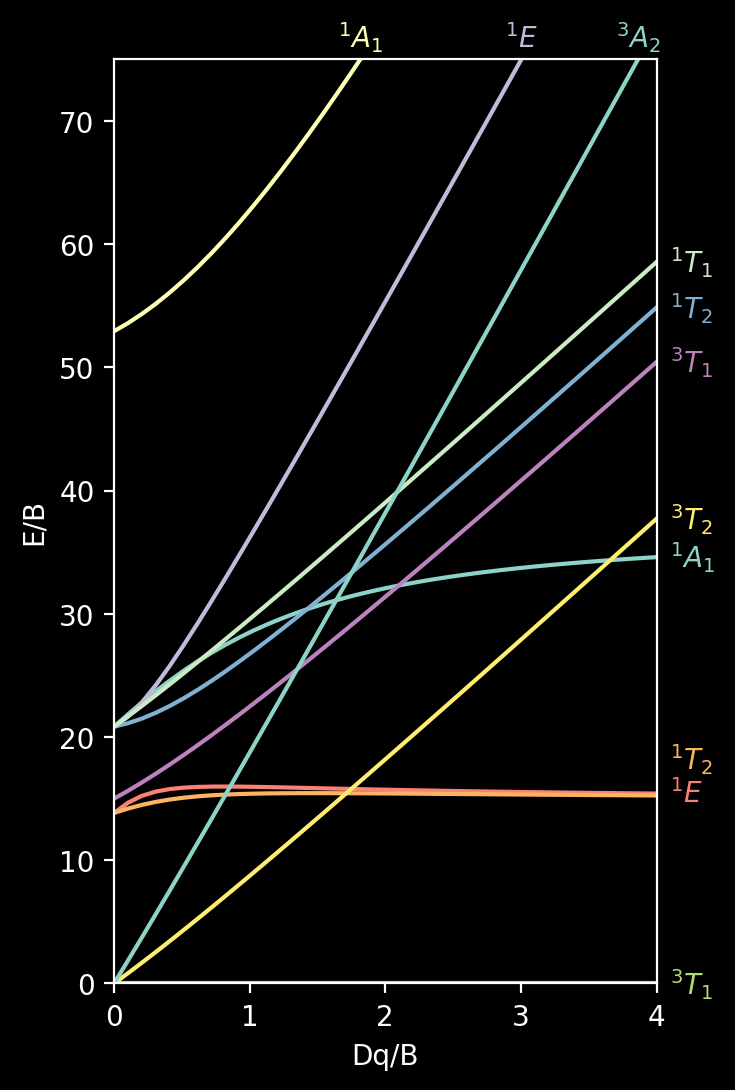

In [174]:
Dqs = np.linspace(0,4,40)
ymax = 75
γexp = 4.42
TSK_functions = TSK_diagrams[2]['numpy functions'] 
base = TSK_functions[(1, sp.Symbol('T_1'))][0](Dqs, γexp)
fig, ax = plt.subplots(figsize=(3.5, 6))
y_strs = []

for term_key, functions in TSK_functions.items():
    for function in functions:
        label_str = '${}^{%d}%s$' % (term_key[0]*2+1, sp.latex(term_key[1]))
        p = plt.plot(Dqs, function(Dqs, γexp) - base)
        col = p[0].get_color()
        y_str = function(Dqs[-1], γexp) - base[-1]
        if y_str < ymax:
            if len(y_strs)>0:
                if np.min(np.abs(np.array(y_strs)-y_str)) < 2:
                    y_str += 3
            ax.text(Dqs[-1]+0.1, y_str,label_str, c = col, va='center')
            y_strs.append(y_str)
        else:
            x_str = np.interp(ymax, function(Dqs, γexp) - base, Dqs)
            ax.text(x_str, ymax+1, label_str, c = col, ha ='center')
ax.set_xlim(0, Dqs[-1])
ax.set_ylim(0, ymax)
ax.set_xlabel('Dq/B')
ax.set_ylabel('E/B')
# plt.tight_layout()
plt.show()

# Second Approach - Proper Block Diagonalization & Letting go Of Simplification

In [175]:
num_electrons = 2

In [269]:
def symmetry_adapted_basis_standard(group_label, lmax, verbose=False):
    '''
    This function takes a  label  for a crystallographic point group and a
    maximum  value for l, and it constructs the symmetry adapted bases for
    all  of the irreducible representations of the group by taking the Ylm
    as the generating functions.

    The  result  is  a dictionary whose keys are symbols for the different
    irreducible   representations  of  the  group  and  whose  values  are
    dictionaries  whose keys are values of l and whose values are lists of
    lists  of  Qets  (in  chunks  of  length  equal  to  the  size  of the
    corresponding  irrep) that represent the linear combinations that form
    bases  that  transform  according  to  the irreducible representation.

    An  empty list means that the corresponding irreducible representation
    is not contained in the subspace for the corresponding value of l.

    Parameters
    ----------
    group_label    (str): a label for a crystallographic point group
    lmax           (int): up  to  which  value  of the l the bases will be 
                          constructed.

    Returns
    -------

    all_symmetry_bases (dict): a dictionary whose keys correspond to group
    labels,  whose  values  are  dictionaries,  whose  keys  correspond to
    symbols    for   irreducible   representations,   whose   values   are
    dictionaries,  whose  keys  are  values  of l, whose values are lists,
    whose   elements   lists,  whose  elements  are  qets  that  represent
    combinations  of spherical harmonics. How many qets there are on these
    final   lists  corresponds  to  the  dimension  of  the  corresponding
    irreducible  representation,  and  how  many of these lists there are,
    corresponds to a possible degeneracy in the correspondig value of l.

    '''
    # The GramSchmidt routine from sympy fails in an odd case,
    # because of this I had to replace it with a custom version.
    GramSchmidtFun = GramSchmidtAlt
    group = CPGs.get_group_by_label(group_label)
    group_irreps = group.irrep_labels
    symmetry_basis = {}
    for group_irrep in group_irreps:
        if verbose:
            print(str(group_irrep))
        irrep_dim = group.irrep_dims[group_irrep]
        symmetry_basis[group_irrep] = {}
        irrep_matrices = group.irrep_matrices[group_irrep]
        for l in range(lmax+1):
            full_basis = [(l,m) for m in range(-l,l+1)] 
            all_phis = {}
            for m in range(-l,l+1):
                phis = {}
                # for a fixed row t,
                for t in range(irrep_dim):
                    # collect of of the sums by adding over columns
                    phi = Qet({})
                    for s in range(irrep_dim):
                        for R, DR in irrep_matrices.items():
                            dr = sp.conjugate(DR[t,s])
                            op_params = group.euler_angles[R]
                            if dr != 0:
                                phi = phi + dr*RYlm(l,m,op_params)
                        phis[(t,s)] = (sp.S(irrep_dim)/group.order)*phi
                all_phis[m] = phis
            # Take the qets and find the coefficients in the basis full_basis
            # this is necessary to evaluate linear independence, and useful
            # for applying the Gram-Schmidt orthonormalization process.
            coord_vecs = []
            for m,s,t in product(range(-l,l+1),range(irrep_dim),range(irrep_dim)):
                coord_vecs.append(all_phis[m][(t,s)].vec_in_basis(full_basis))
            if verbose:
                print("Constructing a big matrix with coordinates in standard basis....")
            bigmatrix = sp.Matrix(coord_vecs)
            # display(bigmatrix)
            num_lin_indep_rows = (bigmatrix.rank())
            good_rows = []
            if num_lin_indep_rows != 0:
                if verbose:
                    print("There are %d linearly independent entries..." % (num_lin_indep_rows))
                    print("Collecting that many, and in groups of %d, from the original set..." % irrep_dim)
                assert (bigmatrix.rows % irrep_dim) == 0, "No. of indep entries should divide the dim of the irrep."
                # determine what groupings have the full rank of the matrix
                chunks = [(coord_vecs[i*irrep_dim : (i*irrep_dim + irrep_dim)]) for i in range(bigmatrix.rows // irrep_dim)]
                cycles = num_lin_indep_rows // irrep_dim
                chunks = [tuple(map(tuple,chunk)) for chunk in chunks if (sp.Matrix(chunk).rank() == irrep_dim)]
                chunks = list(set(chunks))

                for bits in combinations(chunks,cycles):
                    mbits = list(map(lambda x: [sp.Matrix(x)], bits))
                    tot = sp.Matrix(sp.BlockMatrix(mbits))
                    if tot.rank() == num_lin_indep_rows:
                        # a satisfactory subset has been found, exit
                        break
                else:
                    raise Exception("Couldn't find an adequate subset of rows.")
                for bit in bits:
                    good_rows.append(bit)
                if verbose:
                    print("Orthonormalizing ...")
                # convert the coefficient vectors back to qets
                flat_rows = []
                degeneracy = len(good_rows)
                for rows in good_rows:
                    flat_rows.extend(rows)
                flat_rows = list(map(sp.Matrix,flat_rows))
                normalized = GramSchmidtFun(flat_rows, orthonormal=True)
                parts = []
                for deg in range(degeneracy):
                    chunk = list(map(list,normalized[deg*irrep_dim : deg*irrep_dim + irrep_dim]))
                    parts.append(chunk)
                all_normal_qets = []
                for part in parts:
                    normal_qets = [Qet({k: v for k,v in zip(full_basis,part[i]) if v!=0}) for i in range(len(part))]
                    all_normal_qets.append(normal_qets)
                if verbose:
                    print("Finished!")
                symmetry_basis[group_irrep][l] = all_normal_qets
            else:
                symmetry_basis[group_irrep][l] = []
    return symmetry_basis


In [277]:
from gen_bases_real import symmetry_adapted_basis_v_real

In [272]:
ξqet = symmetry_adapted_basis_standard('O',2)[sp.Symbol('T_2')][2][0][0]
ϕqet = symmetry_adapted_basis_standard('O',2)[sp.Symbol('T_2')][2][0][1]
((sp.arg(ϕqet.dict[(2,-1)]) + sp.arg(ϕqet.dict[(2,1)])) 
- (sp.arg(ξqet.dict[(2,-2)]) + sp.arg(ξqet.dict[(2,2)])))

0

In [280]:
ξqet = symmetry_adapted_basis_v_real('O',2,)[1][sp.Symbol('T_2')][2][0][0]
ϕqet = symmetry_adapted_basis_v_real('O',2,)[1][sp.Symbol('T_2')][2][0][1]
((sp.arg(ϕqet.dict[(2,-1)]) + sp.arg(ϕqet.dict[(2,1)])) 
- (sp.arg(ξqet.dict[(2,-2)]) + sp.arg(ξqet.dict[(2,2)])))

........

pi

In [242]:
for op in group.generators:
    display(op)
    print(group.euler_angles[op])

C_{4x}^{-1}

[pi/2, pi/2, -pi/2, 1]


C_{2a}

[0, pi, pi/2, 1]


In [293]:
group_label = 'O'
l = 2
group = CPGs.get_group_by_label(group_label)
irreps = group.irrep_labels
sym_bases = {k: v[l] for k,v in symmetry_bases[group_label].items() if v[l]}
component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
basis_change = {}
for irrep, qets in sym_bases.items():
    components = component_labels[irrep]
    if isinstance(qets, list):
        qets = qets[0]
    for component, qet in zip(components, qets):
        basis_change[component] = qet

In [177]:
two_electrons = []
for config in config_layout('O', 2, num_electrons):
    Γ1s = config[0]
    if len(config) == 1:
        Γ2s = []
    else:
        Γ2s = config[1]
    two_electrons.append((config,CrystalElectronsLLCoupling('O', Γ1s, Γ2s)))

In [178]:
all_terms = OrderedDict()
all_qets = {}
Λ = namedtuple('Λ',['electrons','term','γ']) 
for two_e_config in two_electrons:
    for wave_key, wave_qet in two_e_config[1].equiv_waves.items():
        term_sector = wave_key.terms[-1]
        term_pivot = component_labels[term_sector[1]][0]
        all_qets[wave_key] = wave_qet
        if term_sector not in all_terms:
            all_terms[term_sector] = OrderedDict()
        if wave_key.γ == term_pivot:
            all_terms[term_sector][wave_key] = (wave_qet)

In [201]:
for k, qet in all_terms[(0,sp.Symbol('A_1'))].items():
    print(k)
    display(qet.as_ket())
    break
the_braket_0 = double_electron_braket(qet, qet)
the_braket_1 = braket_basis_change(the_braket_0, basis_change)
the_braket_2 = the_braket_1.apply(to_slater_params)
the_braket_3 = sp.expand(the_braket_2.as_symbol_sum()).subs(slater_to_Racah)
the_braket_3 = the_braket_3.subs(gamma_ratio)
single_elec_element = single_electron_braket(qet, qet).apply(simple_energy).as_symbol_sum()
the_braket_4 = the_braket_3 + single_elec_element

Ψ(electrons=(T_2, T_2), terms=((1/2, T_2), (1/2, T_2), (0, A_1)), γ={\alpha}, S=0, M=0)


-sqrt(3)*|(\bar{{\chi}}, {\chi})>/3 - sqrt(3)*|(\bar{{\phi}}, {\phi})>/3 - sqrt(3)*|(\bar{{\xi}}, {\xi})>/3

In [202]:
display(the_braket_0.as_braket())

<{\chi}{\chi}|{\chi}{\chi}>/3 + <{\chi}{\chi}|{\phi}{\phi}>/3 + <{\chi}{\chi}|{\xi}{\xi}>/3 + <{\phi}{\phi}|{\chi}{\chi}>/3 + <{\phi}{\phi}|{\phi}{\phi}>/3 + <{\phi}{\phi}|{\xi}{\xi}>/3 + <{\xi}{\xi}|{\chi}{\chi}>/3 + <{\xi}{\xi}|{\phi}{\phi}>/3 + <{\xi}{\xi}|{\xi}{\xi}>/3

In [179]:
# single_e_basis = component_labels[sp.Symbol('E')] + component_labels[sp.Symbol('T_2')]
# # add spin up and spin down
# spin_orbitals = [bar_symbol(v) for v in single_e_basis] + single_e_basis
# # create determinantal states
# standard_basis = list(combinations(spin_orbitals,num_electrons))
# # standard_basis = [Qet({k:1}) for k in slater_dets]

In [180]:
standard_basis = list(set(sum([list(qet.dict.keys()) for qet in all_qets.values()],[])))

In [181]:
# checking the basis
big_matrix = sp.Matrix([qet.vec_in_basis(standard_basis) for qet in all_qets.values()])
sp.conjugate(big_matrix)*big_matrix.T == sp.eye(big_matrix.rows)

True

In [182]:
def simple_energy(qnums, coeff):
    Dq = sp.Symbol('B')*sp.Symbol('Dq')
    the_dict = {Dq:0}
    γ1, γ2 = qnums
    if γ1 == γ2:
        the_irrep = determine_irrep(γ1)
        if the_irrep == sp.Symbol('E'):
            the_dict[Dq] += coeff*6
        else:
            the_dict[Dq] += -coeff*4
    if the_dict[Dq] == 0:
        return {}
    return the_dict


In [183]:
solution = {'matrices': {},
            'sympy expressions': {},
            'numpy functions': {}}
gamma_ratio = {sp.Symbol('C'): sp.Symbol('\\gamma_{CB}') * sp.Symbol('B')}
for term, term_waves in all_terms.items():
    # if term != (0, sp.Symbol('A_1')):
    #     continue
    this_waves = term_waves
    print(term, len(term_waves))
    energy_matrix = []
    for qet0 in term_waves.values():
        row = []
        for qet1 in term_waves.values():
            matrix_element = double_electron_braket(qet0, qet1)
            matrix_element = braket_basis_change(matrix_element, basis_change)
            matrix_element = matrix_element.apply(to_slater_params)
            mat_element = sp.expand(matrix_element.as_symbol_sum()).subs(slater_to_Racah)
            mat_element = mat_element.subs(gamma_ratio)
            single_elec_element = single_electron_braket(qet0, qet1).apply(simple_energy).as_symbol_sum()
            row.append(mat_element + single_elec_element)
        #     break
        # break
        energy_matrix.append(row)
    energy_matrix = sp.Matrix(energy_matrix)
    energy_matrix = sp.expand(energy_matrix/sp.Symbol('B')).subs({sp.Symbol('A'):0})
    the_block = block_form(energy_matrix)[1][0]
    solution['matrices'][term] = the_block
    try:
        eigenfuns = list(the_block.eigenvals().keys())
        solution['sympy expressions'][term] = eigenfuns
        solution['numpy functions'][term] = [sp.lambdify((sp.Symbol('Dq'),sp.Symbol('\\gamma_{CB}')), eigenfun) for eigenfun in eigenfuns]
    except:
        solution['sympy expressions'][term] = None
        solution['numpy functions'][term] = None

(0, A_1) 2
(0, E) 2
(1, T_1) 6
(0, T_2) 2
(1, T_2) 3
(0, T_1) 1
(1, A_2) 3


In [290]:
basis_change

{{\gamma}: Qet({(2, 0): 1}),
 {\zeta}: Qet({(2, -2): sqrt(2)/2, (2, 2): sqrt(2)/2}),
 {\xi}: Qet({(2, -2): -1/2 - I/2, (2, 2): 1/2 + I/2}),
 {\phi}: Qet({(2, -1): -1/2 - I/2, (2, 1): 1/2 + I/2}),
 {\chi}: Qet({(2, -1): 1/2 - I/2, (2, 1): 1/2 - I/2})}

In [281]:
sphi, sxi = (list(basis_change.keys())[3], list(basis_change.keys())[2])

In [286]:
list(special_basis_change.values())[0]

Qet({(2, -1): sqrt(2)*exp(I*\theta_1)/2, (2, 1): sqrt(2)*exp(I*\theta_2)/2})

In [287]:
list(special_basis_change.values())[0].dual()

Qet({(2, -1): sqrt(2)*exp(-I*\theta_1)/2, (2, 1): sqrt(2)*exp(-I*\theta_2)/2})

In [ ]:
four_real_var_ids, four_symbol_ids, two_real_var_ids, two_symbol_ids, simplifier = braket_identities('O', assume_real = False, verbose=False)

In [295]:
I = sp.I
ϕ1, ϕ2, ϕ3, ϕ4 = [sp.Symbol('\\theta_%d' % i,  real=True) for i in [1,2,3,4]]
special_basis_change = {sphi: Qet({(2, -1): sp.S(1)/sp.sqrt(2)*sp.exp(I*ϕ1), (2, 1): sp.S(1)/sp.sqrt(2)*sp.exp(I*ϕ2)}),
                        sxi: Qet({(2, -2): sp.S(1)/sp.sqrt(2)*sp.exp(I*ϕ3), (2, 2): sp.S(1)/sp.sqrt(2)*sp.exp(I*ϕ4)})}
# special_basis_change = {sphi: Qet({(2, -1): 1, (2, 1): 1}),
#                         sxi: Qet({(2, -2): 1, (2, 2): 1})}
matrix_element = Qet({(sp.Symbol('{\\xi}'),)*2+(sp.Symbol('{\\phi}'),)*2:1})
display(matrix_element.as_braket())
matrix_element = braket_basis_change(matrix_element, special_basis_change)
matrix_element = matrix_element.apply(to_slater_params)
mat_element = sp.expand(matrix_element.as_symbol_sum()).subs(slater_to_Racah)
display(sp.simplify(mat_element))

<{\xi}{\xi}|{\phi}{\phi}>

-(3*B + C)*exp(I*(\theta_1 + \theta_2 - \theta_3 - \theta_4))

In [ ]:
list(set([x for x in four_real_var_ids.values()]))

In [352]:
simplifier(double_electron_braket(qet0, qet0)).as_braket()

2*<{\xi}{\xi}|{\phi}{\phi}> + <{\xi}{\xi}|{\xi}{\xi}>

In [373]:
sp.simplify(((basis_change[sp.Symbol('{\\xi}')]).dual()
            *(basis_change[sp.Symbol('{\\xi}')]).dual()
            *basis_change[sp.Symbol('{\\phi}')]
            *basis_change[sp.Symbol('{\\phi}')]).apply(to_slater_params).as_symbol_sum().subs(slater_to_Racah))

-3*B - C

In [360]:
ah = sp.simplify(((basis_change[sp.Symbol('{\\xi}')]).dual()*(basis_change[sp.Symbol('{\\xi}')]).dual()*basis_change[sp.Symbol('{\\phi}')]*basis_change[sp.Symbol('{\\phi}')]).apply(to_slater_params).as_symbol_sum()).subs(slater_to_Racah)
display(ah)
ah = sp.simplify(((basis_change[sp.Symbol('{\\phi}')]).dual()*(basis_change[sp.Symbol('{\\phi}')]).dual()*basis_change[sp.Symbol('{\\chi}')]*basis_change[sp.Symbol('{\\chi}')]).apply(to_slater_params).as_symbol_sum()).subs(slater_to_Racah)
display(ah)

-3*B - C

3*B + C

In [410]:
component = sp.Symbol('{\\chi}')
idx = list(new_labels[group_label][sp.Symbol('T_2')].values()).index(component)
qet = basis_change[component]
display(qet.as_ket())
R = group.generators[0]
rqet = sum([v*RYlm(*k,group.euler_angles[R]) for k,v in qet.dict.items()],Qet())
rqet = Qet({k:sp.simplify(v) for k,v in rqet.dict.items()})
display(rqet.as_ket())
DR = group.irrep_matrices[sp.Symbol('T_2')][R]
irrep_dim = 3
irrep_way = sum([DR[k,idx]*qets[k] for k in range(irrep_dim)],Qet())
display( irrep_way.as_ket() )
display( (irrep_way-rqet).simplify().as_ket() )

(1/2 - I/2)*|(2, -1)> + (1/2 - I/2)*|(2, 1)>

I*(-1 + I)*|(2, -2)>/2 + (1/2 + I/2)*|(2, 2)>

(-1/2 - I/2)*|(2, -2)> + (1/2 + I/2)*|(2, 2)>

0

In [411]:
rqet.simplify()

AttributeError: 'Qet' object has no attribute 'simplify'

In [297]:
for k, q in basis_change.items():
    print(k)
    display(k)
    display(q.as_ket())

{\gamma}


{\gamma}

|(2, 0)>

{\zeta}


{\zeta}

sqrt(2)*|(2, -2)>/2 + sqrt(2)*|(2, 2)>/2

{\xi}


{\xi}

(-1/2 - I/2)*|(2, -2)> + (1/2 + I/2)*|(2, 2)>

{\phi}


{\phi}

(-1/2 - I/2)*|(2, -1)> + (1/2 + I/2)*|(2, 1)>

{\chi}


{\chi}

(1/2 - I/2)*|(2, -1)> + (1/2 - I/2)*|(2, 1)>

In [303]:
# check by hand
term_qets = list(all_terms[(0,sp.Symbol('A_1'))].values())
qet0 = term_qets[0]
display(qet0.as_braket())
matrix_element = double_electron_braket(qet0, qet0)
# display(matrix_element.as_braket())
# matrix_element = braket_basis_change(matrix_element, basis_change)
# # matrix_element = matrix_element.apply(to_slater_params
# # mat_element = sp.expand(matrix_element.as_symbol_sum()).subs(slater_to_Racah)
# # mat_element = mat_element.subs(gamma_ratio)
# # single_elec_element = single_electron_braket(qet0, qet1).apply(simple_energy).as_symbol_sum()
# # row.append(mat_element + single_elec_element)

-sqrt(3)*<\bar{{\chi}}|{\chi}>/3 - sqrt(3)*<\bar{{\phi}}|{\phi}>/3 - sqrt(3)*<\bar{{\xi}}|{\xi}>/3

In [304]:
# def rsimp(qnums,coeff):
#     l1, m1, l2, m2, l1p, m1p, l2p, m2p = qnums
#     coeff = sp.simplify(coeff)
#     if m1 + m2 == m1p + m2p:
#         return {(m1,m2,m1p,m2p): coeff}
#     else:
#         return {}
# matrix_element = Qet({(sp.Symbol('{\\xi}'),)*2+(sp.Symbol('{\\phi}'),)*2:1})
# matrix_element = braket_basis_change(matrix_element, basis_change)
# matrix_element.apply(rsimp).as_braket()

In [305]:
# m1, m2, m1p, m2p = -2,2,-1,1
# mk = m1-m1p
# sp.S(-1)**(m1-m1p)*sum([(sp.Symbol('F^{%d}' % k)*((4*sp.pi) / (2*k+1))*threeHarmonicIntegral(2,m1,k,m1-m1p,2,m1p)*threeHarmonicIntegral(2,m2,k,m2-m2p,2,m2p)) for k in range(7)])

In [306]:
# tqet = Qet({(-2,-2,-2,-2):1,
#             (-2,2,-2,2):1,
#             (-2,2,2,-2):1,
#             (2,-2,-2,2):1,
#             (2,-2,2,-2):1,
#             (2,2,2,2):1}).apply(to_slater_params)
# (tqet.as_symbol_sum().subs(slater_to_Racah))/4

In [317]:
atoms = [Qet({k:1}) for k,v in matrix_element.dict.items()]
def partition(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
atoms = list(partition(atoms,3))
atomrows = []
all_elements = []
compare = []
for row in atoms:
    atomrow = []
    for qet in row:
        compare.append(qet.as_braket())
        melemen = braket_basis_change(qet, basis_change).apply(to_slater_params).as_symbol_sum().subs(slater_to_Racah)
        melemen = sp.simplify(melemen)
        all_elements.append(melemen)
        atomrow.append(melemen)
    atomrows.append(atomrow)
atomrows = sp.Matrix(atomrows)
display(sp.Matrix(list(partition(compare,3))))
display(atomrows)
display(sum(all_elements))

Matrix([
[  <{\xi}{\xi}|{\xi}{\xi}>,   <{\xi}{\xi}|{\phi}{\phi}>,   <{\xi}{\xi}|{\chi}{\chi}>],
[<{\phi}{\phi}|{\xi}{\xi}>, <{\phi}{\phi}|{\phi}{\phi}>, <{\phi}{\phi}|{\chi}{\chi}>],
[<{\chi}{\chi}|{\xi}{\xi}>, <{\chi}{\chi}|{\phi}{\phi}>, <{\chi}{\chi}|{\chi}{\chi}>]])

Matrix([
[A + 4*B + 3*C,      -3*B - C,      -3*B - C],
[     -3*B - C, A + 4*B + 3*C,       3*B + C],
[     -3*B - C,       3*B + C, A + 4*B + 3*C]])

3*A + 6*B + 7*C

In [331]:
3*(A+4*B+3*C) + (3*B+C)*6

3*A + 30*B + 15*C

In [344]:
term_qets = list(all_terms[(0,sp.Symbol('A_1'))].values())
qet0 = term_qets[0]
display(qet0.as_braket())
matrix_element = double_electron_braket(qet0, qet0, False)
display(matrix_element.as_braket())

-sqrt(3)*<\bar{{\chi}}|{\chi}>/3 - sqrt(3)*<\bar{{\phi}}|{\phi}>/3 - sqrt(3)*<\bar{{\xi}}|{\xi}>/3

<\bar{{\chi}}{\chi}|\bar{{\phi}}{\phi}>/3 + <\bar{{\chi}}{\chi}|\bar{{\xi}}{\xi}>/3 + <\bar{{\phi}}{\phi}|\bar{{\chi}}{\chi}>/3 + <\bar{{\phi}}{\phi}|\bar{{\xi}}{\xi}>/3 + <\bar{{\xi}}{\xi}|\bar{{\chi}}{\chi}>/3 + <\bar{{\xi}}{\xi}|\bar{{\phi}}{\phi}>/3 + <{\chi}\bar{{\chi}}|{\chi}\bar{{\chi}}>/3 + <{\phi}\bar{{\phi}}|{\phi}\bar{{\phi}}>/3 + <{\xi}\bar{{\xi}}|{\xi}\bar{{\xi}}>/3

In [341]:
sp.simplify(braket_basis_change(matrix_element, basis_change).apply(to_slater_params).as_symbol_sum().subs(slater_to_Racah))

A + 2*B + 7*C/3

In [325]:
sp.simplify(braket_basis_change(matrix_element, basis_change).apply(to_slater_params).as_symbol_sum().subs(slater_to_Racah))

A + 2*B + 7*C/3

In [191]:
for term, matrix in solution['matrices'].items():
    print(term)
    display(sp.expand(sp.Symbol('B')*matrix.subs({sp.Symbol('Dq'):0,sp.Symbol('\\gamma_{CB}'): sp.Symbol('C')/sp.Symbol('B')})))

(0, A_1)


Matrix([
[                    2*B + 7*C/3, -2*sqrt(6)*I*B/3 - sqrt(6)*I*C/3],
[2*sqrt(6)*I*B/3 + sqrt(6)*I*C/3,                        8*B + 4*C]])

(0, E)


Matrix([
[    9*B + 14*C/3, 2*sqrt(3)*I*B/3],
[-2*sqrt(3)*I*B/3,             2*C]])

(1, T_1)


Matrix([
[                           -5*B, 3*sqrt(2)*B/2 + 3*sqrt(2)*I*B/2],
[3*sqrt(2)*B/2 - 3*sqrt(2)*I*B/2,                            -5*B]])

(0, T_2)


Matrix([
[                B + 2*C, sqrt(6)*B + sqrt(6)*I*B],
[sqrt(6)*B - sqrt(6)*I*B,                     2*C]])

(1, T_2)


Matrix([[-8*B]])

(0, T_1)


Matrix([[B + 2*C]])

(1, A_2)


Matrix([[-8*B]])

/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/juan/opt/anaconda3/envs/qdef3p8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary 

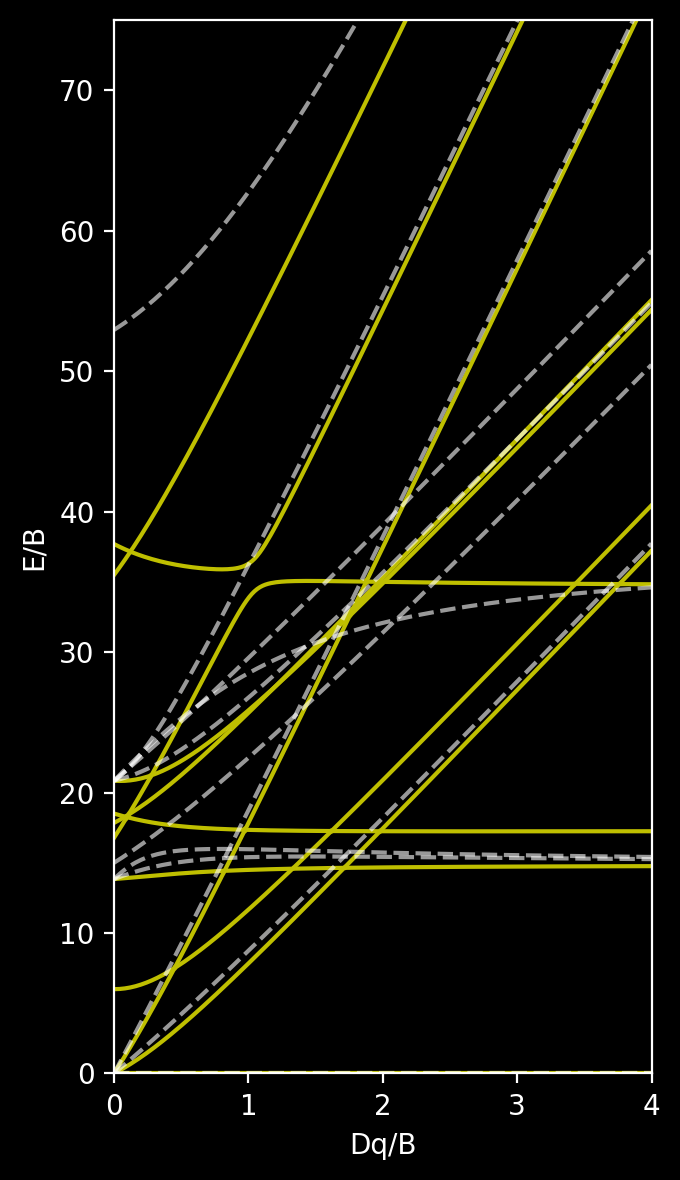

In [21]:
γexp = 4.42
Bexp = 860
ymax = 75

Dqs = np.linspace(0, 4, 200)

TSK_functions = solution['numpy functions']
TSK_matrices = solution['matrices']

if num_electrons in [2]:
    base = TSK_functions[(1, sp.Symbol('T_1'))][0](Dqs, γexp)
fig, ax = plt.subplots(figsize=(3.5, 6))
y_strs = []
spvars = (sp.Symbol('Dq'), sp.Symbol('\\gamma_{CB}'))

array_solution = []
array_sol = True

for Dq in Dqs:
    col = []
    for term_key, term_matrix in TSK_matrices.items():
        num_matrix = term_matrix.subs({sp.Symbol('Dq'): Dq, sp.Symbol('\\gamma_{CB}'): γexp})
        eigenvals = np.linalg.eig(np.array(num_matrix).astype(np.complex64))[0]
        col.extend(eigenvals)
    col = np.array(col)
    col = np.sort(col - np.min(col))
    array_solution.append(col)

array_solution = np.array(array_solution).T

# for term_key in TSK_functions.keys():
#     functions = TSK_functions[term_key]
#     the_matrix = TSK_matrices[term_key]
#     print(".")
#     if functions != None and False:
#         for function in functions:
#             array_solution.append(function(Dqs, γexp))
#     else:
#         array_sol = True
#         for Dq in Dqs:
#             num_matrix = the_matrix.subs({sp.Symbol('Dq'): Dq, sp.Symbol('\\gamma_{CB}'): γexp})
#             eigenvals = np.linalg.eig(np.array(num_matrix).astype(np.float64))[0]
#             array_solution.append(eigenvals)
        
if not array_sol:
    for term_key, functions in TSK_functions.items():
        for function in functions:
            label_str = '${}^{%d}%s$' % (term_key[0]*2+1, sp.latex(term_key[1]))
            p = plt.plot(Dqs, function(Dqs, γexp) - base)
            col = p[0].get_color()
            y_str = function(Dqs[-1], γexp) - base[-1]
            if y_str < ymax:
                if len(y_strs)>0:
                    if np.min(np.abs(np.array(y_strs)-y_str)) < 2:
                        y_str += 3
                ax.text(Dqs[-1]+0.1, y_str,label_str, c = col, va='center')
                y_strs.append(y_str)
            else:
                x_str = np.interp(ymax, function(Dqs, γexp) - base, Dqs)
                ax.text(x_str, ymax+1, label_str, c = col, ha ='center')
else:
    for row in array_solution:
        plt.plot(Dqs, row, 'y-')

if num_electrons in TSK_diagrams:
    if num_electrons in [2]:
        TSK_functions = TSK_diagrams[num_electrons]['numpy functions'] 
        base = TSK_functions[(1, sp.Symbol('T_1'))][0](Dqs, γexp)
        y_strs = []

        for term_key, functions in TSK_functions.items():
            for function in functions:
                label_str = '${}^{%d}%s$' % (term_key[0]*2+1, sp.latex(term_key[1]))
                p = plt.plot(Dqs, function(Dqs, γexp) - base, 'w--', alpha = 0.6)
                col = p[0].get_color()
                y_str = function(Dqs[-1], γexp) - base[-1]
    elif num_electrons in [3]:
        matrices = TSK_diagrams[num_electrons]['matrices']
        array_solution = []
        for Dq in Dqs:
            col = []
            for term_key, term_matrix in matrices.items():
                num_matrix = term_matrix.subs({sp.Symbol('Dq'): Dq, sp.Symbol('\\gamma'): γexp})
                eigenvals = np.linalg.eig(np.array(num_matrix).astype(np.float64))[0]
                col.extend(eigenvals)
            col = np.array(col)
            col = np.sort(col - np.min(col))
            array_solution.append(col)
        array_solution = np.array(array_solution).T
        for row in array_solution:
            plt.plot(Dqs, row, 'r--', lw=1, alpha=0.9)


ax.set_xlim(0, 4)
ax.set_ylim(0, ymax)
ax.set_xlabel('Dq/B')
ax.set_ylabel('E/B')
plt.tight_layout()
plt.show()

In [ ]:
# four_real_var_ids, four_symbol_ids, two_real_var_ids, two_symbol_ids, simplifier = braket_identities('O', assume_real = False, verbose=False)
# # (qet_key0, qet0) = list(all_terms[(0, sp.Symbol('T_1'))].items())[0]
# chunks = []
# schunks = []
# for i in range(9):
#     matrix_element = double_electron_braket(qet0, qet0)
#     matrix_element, val = list(matrix_element.dict.items())[i]
#     matrix_element = Qet({matrix_element:val})
#     smatrix_element = simplifier(matrix_element)
#     # display(matrix_element.as_braket())
#     # display(smatrix_element)
#     matrix_element = braket_basis_change(matrix_element, basis_change)
#     display(matrix_element.as_braket())
#     smatrix_element = braket_basis_change(smatrix_element, basis_change)
#     display(smatrix_element.as_braket())
#     # display(smatrix_element.as_braket())
#     # xxx
#     matrix_element = matrix_element.apply(to_slater_params)
#     smatrix_element = smatrix_element.apply(to_slater_params)
#     # display(matrix_element.as_symbol_sum())
#     mat_element = sp.expand(matrix_element.as_symbol_sum()).subs(slater_to_Racah)
#     mat_element = sp.expand(mat_element)
#     smat_element = sp.expand(smatrix_element.as_symbol_sum()).subs(slater_to_Racah)
#     smat_element = sp.expand(smat_element)
#     display(mat_element)
#     display(smat_element)
#     chunks.append(sp.expand(mat_element))
#     schunks.append(sp.expand(smat_element))
#     if mat_element!= smat_element:
#         print("breaking")
#         break

In [ ]:
# matrix_element = simpler_two_electron_braket(qet0, qet0)
# matrix_element, val = list(matrix_element.dict.items())[i]
# matrix_element = Qet({matrix_element:1})
# display(matrix_element.as_braket())
# smatrix_element = simplifier(matrix_element)
# display(smatrix_element.as_braket())
# # display(smatrix_element)
# matrix_element = braket_basis_change(matrix_element, basis_change)
# display(matrix_element.as_braket())
# smatrix_element = braket_basis_change(smatrix_element, basis_change)
# display(smatrix_element.as_braket())
# # display((smatrix_element + matrix_element).as_braket())
# # display(smatrix_element.as_braket())
# # xxx
# matrix_element = matrix_element.apply(to_slater_params)
# smatrix_element = smatrix_element.apply(to_slater_params)
# # display(matrix_element.as_symbol_sum())
# mat_element = sp.expand(matrix_element.as_symbol_sum()).subs(slater_to_Racah)
# mat_element = sp.expand(mat_element)
# smat_element = sp.expand(smatrix_element.as_symbol_sum()).subs(slater_to_Racah)
# smat_element = sp.expand(smat_element)
# display(mat_element)
# display(smat_element)

In [ ]:
# for k, v in basis_change.items():
#     display(k)
#     display(v.as_braket())

In [ ]:
# matrix_element = double_electron_braket(qet0, qet0)
# display(matrix_element.as_braket())
# matrix_element = braket_basis_change(matrix_element, basis_change)
# display(matrix_element.as_braket())
# matrix_element = matrix_element.apply(to_slater_params)
# mat_element = sp.expand(matrix_element.as_symbol_sum()).subs(slater_to_Racah)
# sp.expand(mat_element)

In [ ]:
# matrix_element = double_electron_braket(qet1,qet0)
# # matrix_element = simplifier(matrix_element)
# matrix_element = braket_basis_change(matrix_element, basis_change)
# matrix_element = matrix_element.apply(to_slater_params)
# mat_element = sp.expand(matrix_element.as_symbol_sum()).subs(slater_to_Racah)
# sp.expand(mat_element)

In [ ]:
# for term_label in blocks:
#     display(Math('{}^{%d}{%s}' % ((term_label[0]*2+1, sp.latex(term_label[1])))))
#     ablock = blocks[term_label].subs({sp.Symbol('Dq'):0, sp.Symbol('A'):0})
#     ablock = sp.expand(ablock)
#     try:
#         ablock = block_form(ablock)
#         display(ablock[1][0])
#     except:
#         display(ablock)

In [1399]:
# det0 = (1,2,3,4)
# det1 = (7,3,8,9)
# set0 = set(det0)
# set1 = set(det1)
# # there should be no repeat symbols in any determinantal state
# assert len(set0) == len(det0) and len(set1) == len(det1), "There's something funny here ..."
# common_symbs = list(set0.intersection(set1))
# different_symbs0 = [x for x in det0 if x not in common_symbs]
# different_symbs1 = [x for x in det1 if x not in common_symbs]
# newdet0 = different_symbs0 + common_symbs
# newdet1 = different_symbs1 + common_symbs
# ordering0 = [det0.index(x) for x in newdet0]
# ordering1 = [det1.index(x) for x in newdet1]
# extra_sign = εijk(*ordering0) * εijk(*ordering1)
# odet0 = newdet0
# odet1 = newdet1
# comparisons = list(map(lambda x: x[0] == x[1], zip(odet0, odet1)))

In [1400]:
# def huh(key, coeff):
#     γ1, γ2, γ3, γ4 = key
#     if γ1 == γ3 or γ2 == γ4:
#         return {key:coeff}
#     else:
#         return {}

In [1401]:
# (qet0*qet0).as_braket()

In [1402]:
# (qet0*qet0).apply(huh).as_braket()

In [1403]:
# atoms = (qet0*qet0).apply(huh).dict
# for atom_k, atom_v in atoms.items():
#     atqet0 = Qet({atom_k[:2]:1})
#     atqet1 = Qet({atom_k[2:]:1})
#     display(Qet({atom_k:1}).as_braket())
#     display(single_electron_braket(atqet0, atqet1).as_braket())

In [1404]:
# single_electron_braket(qet0,qet0).as_braket()

In [1405]:
# for s1, s2, s3 in product(*[[-1,1]]*3):
#     print(s1,s2,s3)
#     print(sp.S(3)/4*6*s1 + sp.S(1)/4*(-4)*s2 + sp.S(1)/4*(6)*s3)

In [1406]:
# (qet0*qet0).as_braket()

In [1407]:
# single_electron_braket(qet0,qet0).apply(another_simplifier)

In [1408]:
# largeDq = 1e20
# the_em = energy_matrix.subs({sp.Symbol('Dq'):largeDq,''})
# the_em_array = np.array(the_em).astype(np.float64)
# eigenvals, eigenvects = np.linalg.eig(the_em_array)
# eigenvals = np.sort(eigenvals/largeDq)
# eigenvals = eigenvals - np.min(eigenvals)
# print(np.round(eigenvals,10))

In [1409]:
energy_matrix_rep = sp.Matrix(energy_matrix)

# Straightforward solution (Jan-07 2022-01-07 10:19:06) - TSK and standard basis agree

In [68]:
def simple_energy(qnums, coeff):
    Dq = sp.Symbol('Dq')
    the_dict = {Dq:0}
    γ1, γ2 = qnums
    if γ1 == γ2:
        the_irrep = determine_irrep(γ1)
        if the_irrep == sp.Symbol('E'):
            the_dict[Dq] += coeff*6
        else:
            the_dict[Dq] += -coeff*4
    if the_dict[Dq] == 0:
        return {}
    return the_dict


In [69]:
group_label = 'O'
l = 2
group = CPGs.get_group_by_label(group_label)
irreps = group.irrep_labels
sym_bases = {k: v[l] for k,v in symmetry_bases[group_label][1].items() if v[l]}
component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
basis_change = {}
for irrep, qets in sym_bases.items():
    components = component_labels[irrep]
    if isinstance(qets, list):
        qets = qets[0]
    for component, qet in zip(components, qets):
        basis_change[component] = qet


## 2 e

In [70]:
num_electrons = 2
single_e_basis = component_labels[sp.Symbol('E')] + component_labels[sp.Symbol('T_2')]
# add spin up and spin down
spin_orbitals = single_e_basis + [bar_symbol(v) for v in single_e_basis]
# create determinantal states
slater_dets = list(combinations(spin_orbitals,num_electrons))
slater_qets = [Qet({k:1}) for k in slater_dets]

In [71]:
hamiltonian = []
for qet0 in slater_qets:
    row = []
    for qet1 in slater_qets:
        double_braket = double_electron_braket(qet0,qet1)
        coulomb_matrix_element = braket_basis_change(double_braket, basis_change)
        coulomb_matrix_element = coulomb_matrix_element.apply(to_slater_params)
        coulomb_matrix_element = sp.expand(coulomb_matrix_element.as_symbol_sum()).subs(slater_to_Racah)
        nuclear_charge_energy = single_electron_braket(qet0,qet1).apply(simple_energy).as_symbol_sum()
        row.append(coulomb_matrix_element + nuclear_charge_energy)
    hamiltonian.append(row)
hamiltonian = sp.Matrix(hamiltonian)

In [72]:
γexp = 4.42
num_ham = hamiltonian.subs({sp.Symbol('A'):0, sp.Symbol('C'): γexp, sp.Symbol('B'):1})

In [73]:
# largeDq = 1e10
# the_ham_array = np.array(num_ham.subs({sp.Symbol('Dq'): largeDq})).astype(np.float64)
# the_eigenvalues = np.round(np.sort(np.linalg.eig(the_ham_array)[0])/largeDq)
# print(the_eigenvalues)

In [74]:
Dqs = np.linspace(0,4,80)
eigen_array = []
for Dq in Dqs:
    the_ham_array = np.array(num_ham.subs({sp.Symbol('Dq'): Dq})).astype(np.float64)
    the_eigenvalues = np.sort(np.linalg.eig(the_ham_array)[0])
    the_eigenvalues = np.real(the_eigenvalues - np.min(the_eigenvalues))
    eigen_array.append(the_eigenvalues)
eigen_array = np.array(eigen_array).T

In [75]:
ion = Ion('V',3)
Bexp = 860
exp_levels = ion.nist_data['Level (eV)'] * UnitCon.con_factor('eV','cm^{-1}')/Bexp
term_labels =  ion.nist_data['Term']
selector = exp_levels<ymax
exp_levels = exp_levels[selector]
term_labels = term_labels[selector]

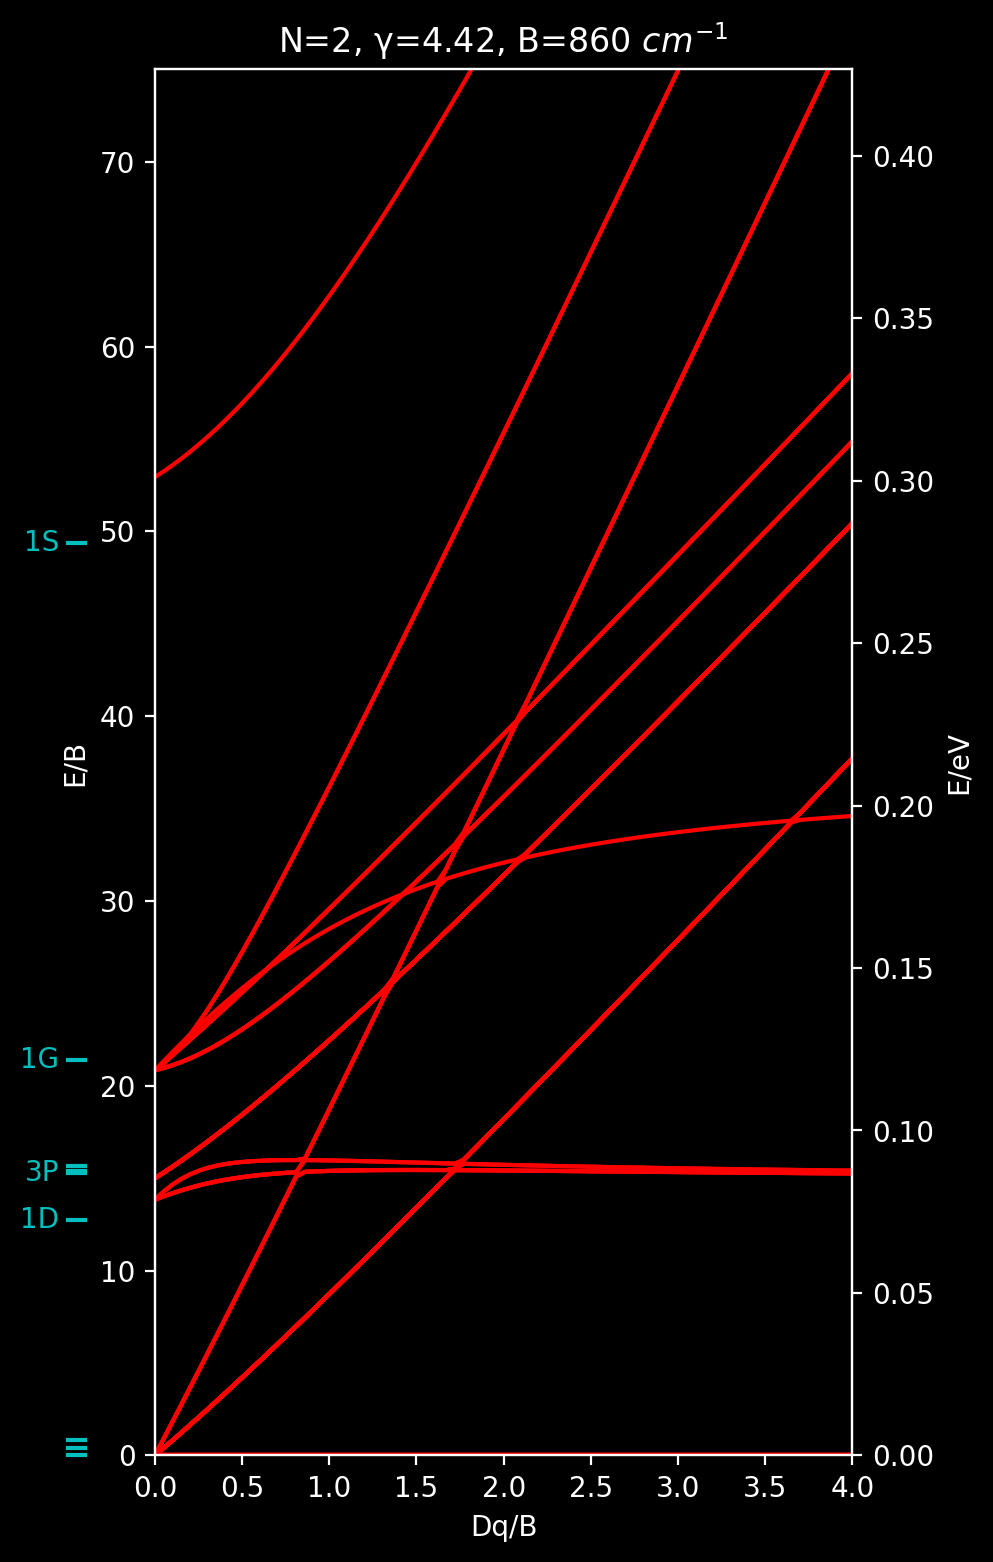

In [76]:
fig, ax = plt.subplots(figsize=(3*1.5,6*1.5))

for row in eigen_array:
    plt.plot(Dqs,row,'r')
y_str = []
for exp_level, term_label in zip(exp_levels, term_labels):
    line = plt.Line2D([-0.5,-0.4],[exp_level]*2,c='c')
    line.set_clip_on(False)
    ax.add_line(line)
    if len(y_str)>0 and min(([abs(ys - exp_level) for ys in y_str])) > 2:
        plt.text(-0.55,exp_level,term_label,ha='right', va='center', c='c')
    y_str.append(exp_level)
plt.xlim(0,Dqs[-1])
plt.ylim(0,ymax)
plt.xlabel('Dq/B')
plt.ylabel('E/B')
axright = ax.twinx()  # instantiate a second axes that shares the same x-axis
axright.set_ylim(0, Dqs[-1]*Bexp*UnitCon.con_factor('cm^{-1}','eV'))
axright.set_ylabel('E/eV')
plt.title('N=%d, γ=%.2f, B=%.0f $cm^{-1}$' % (num_electrons, γexp, Bexp))
plt.show()

## All TSK figures

N=2


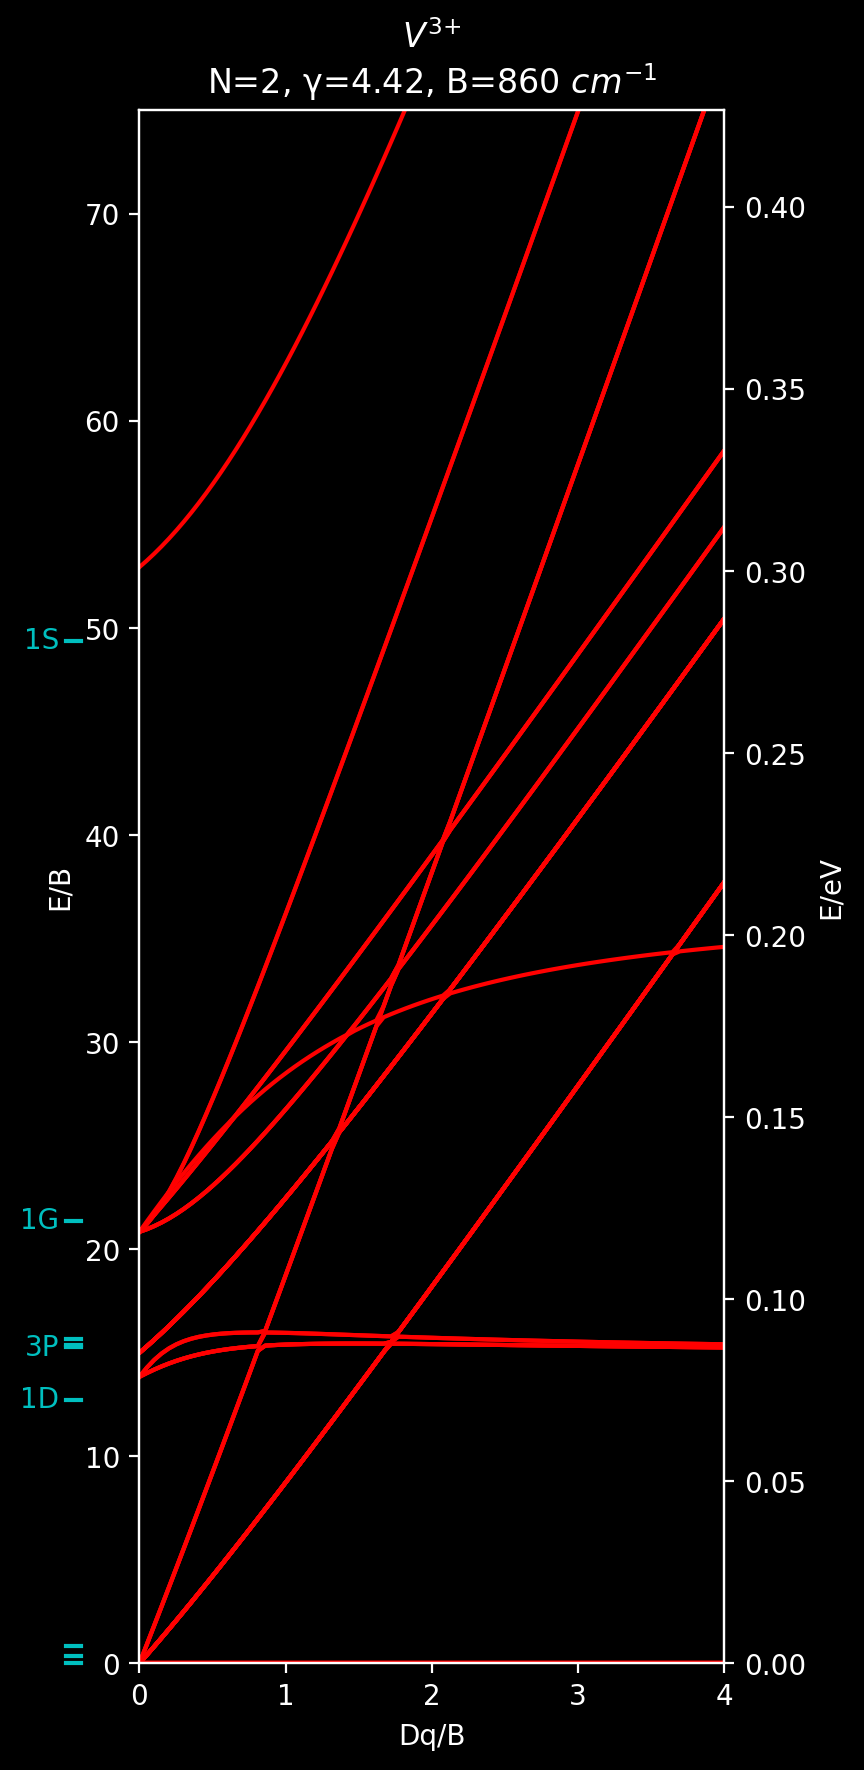

N=3


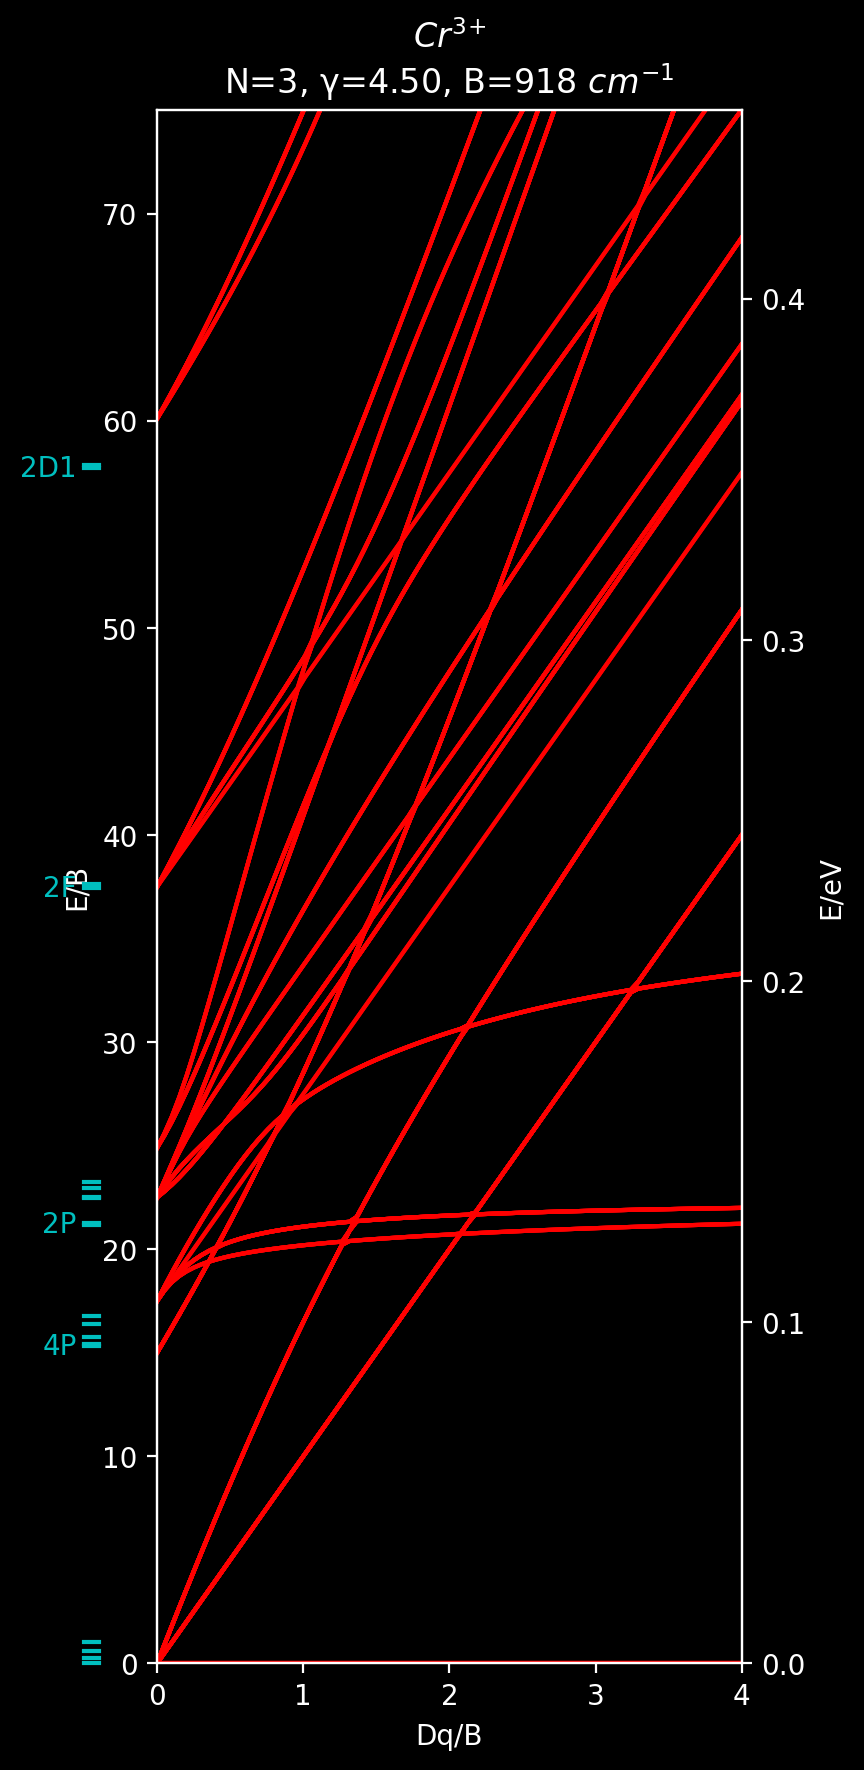

N=4


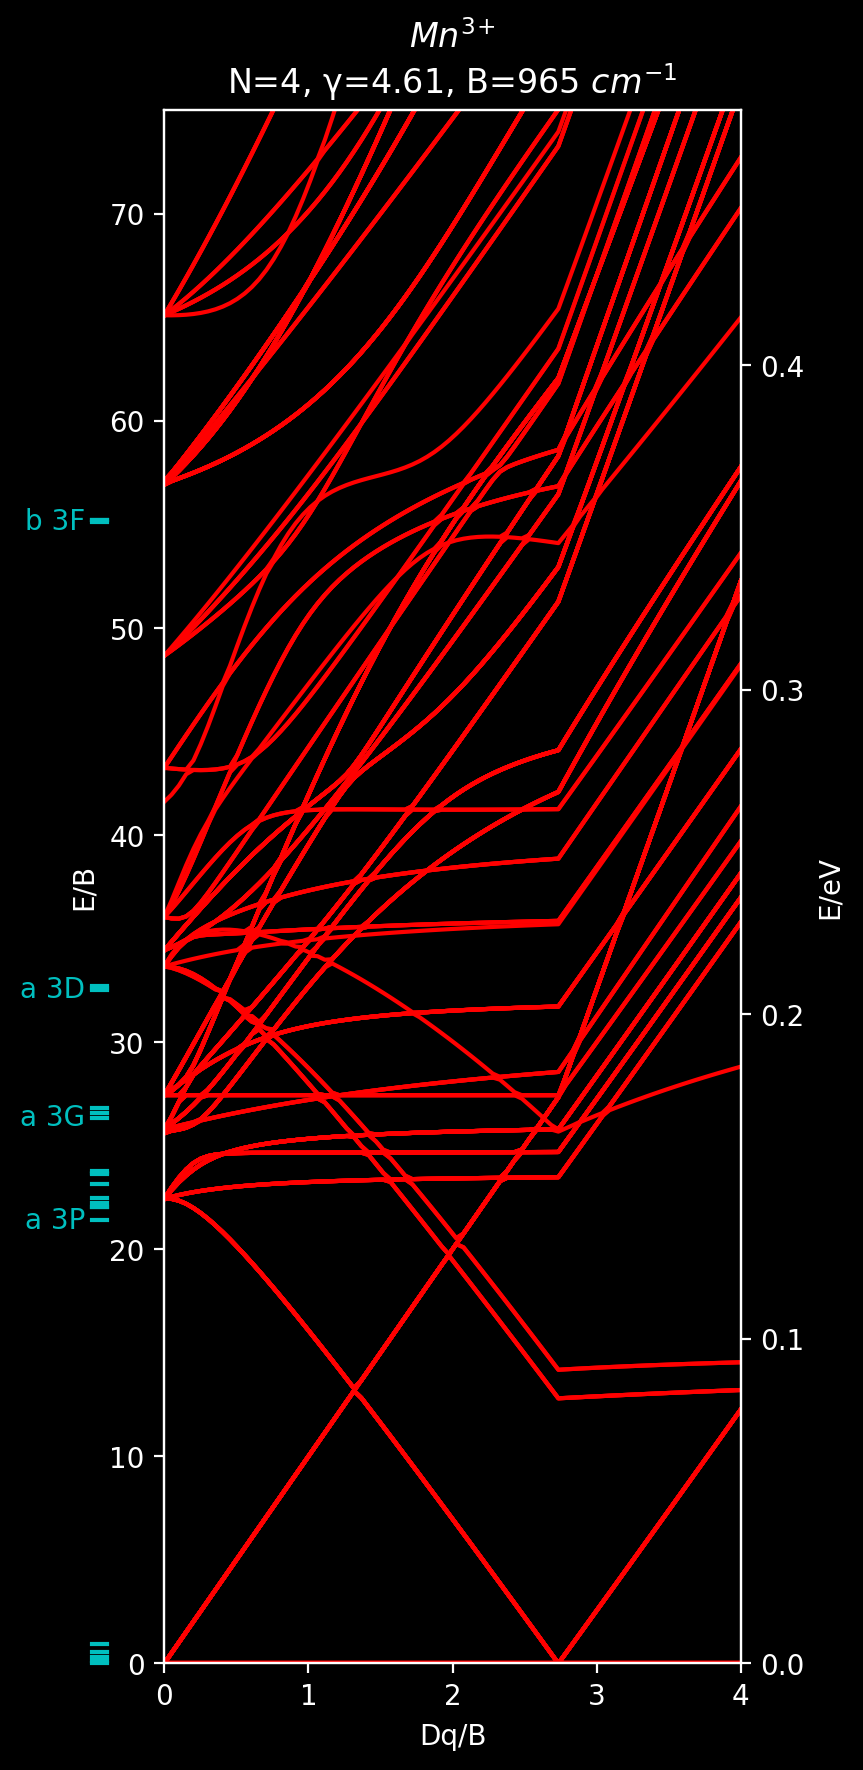

N=5


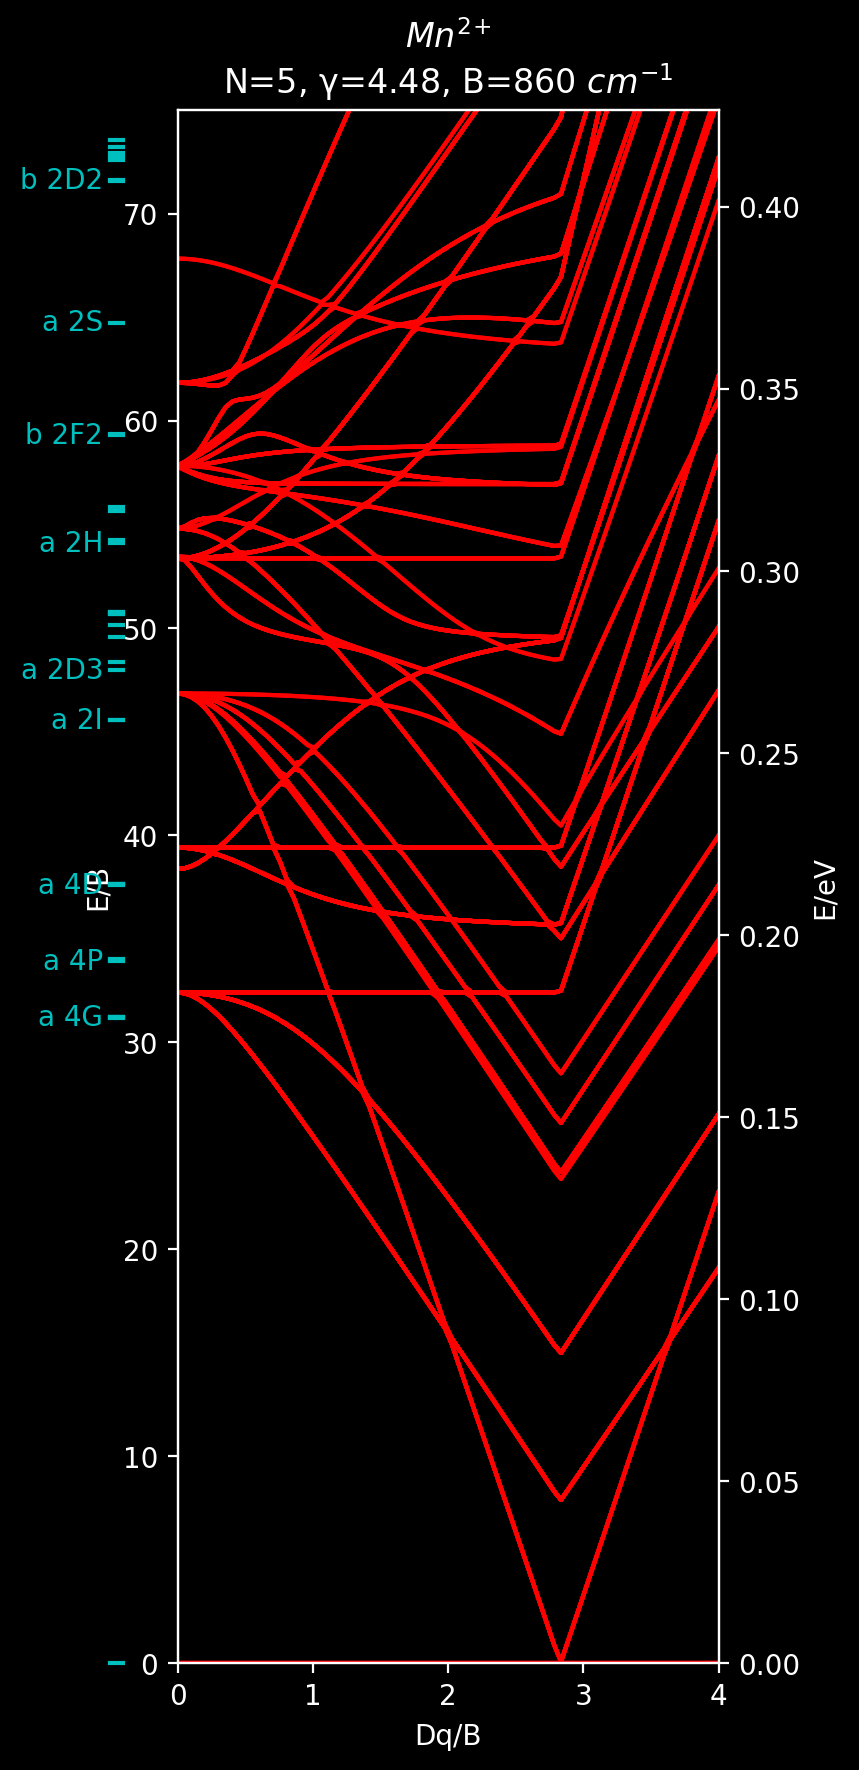

N=6


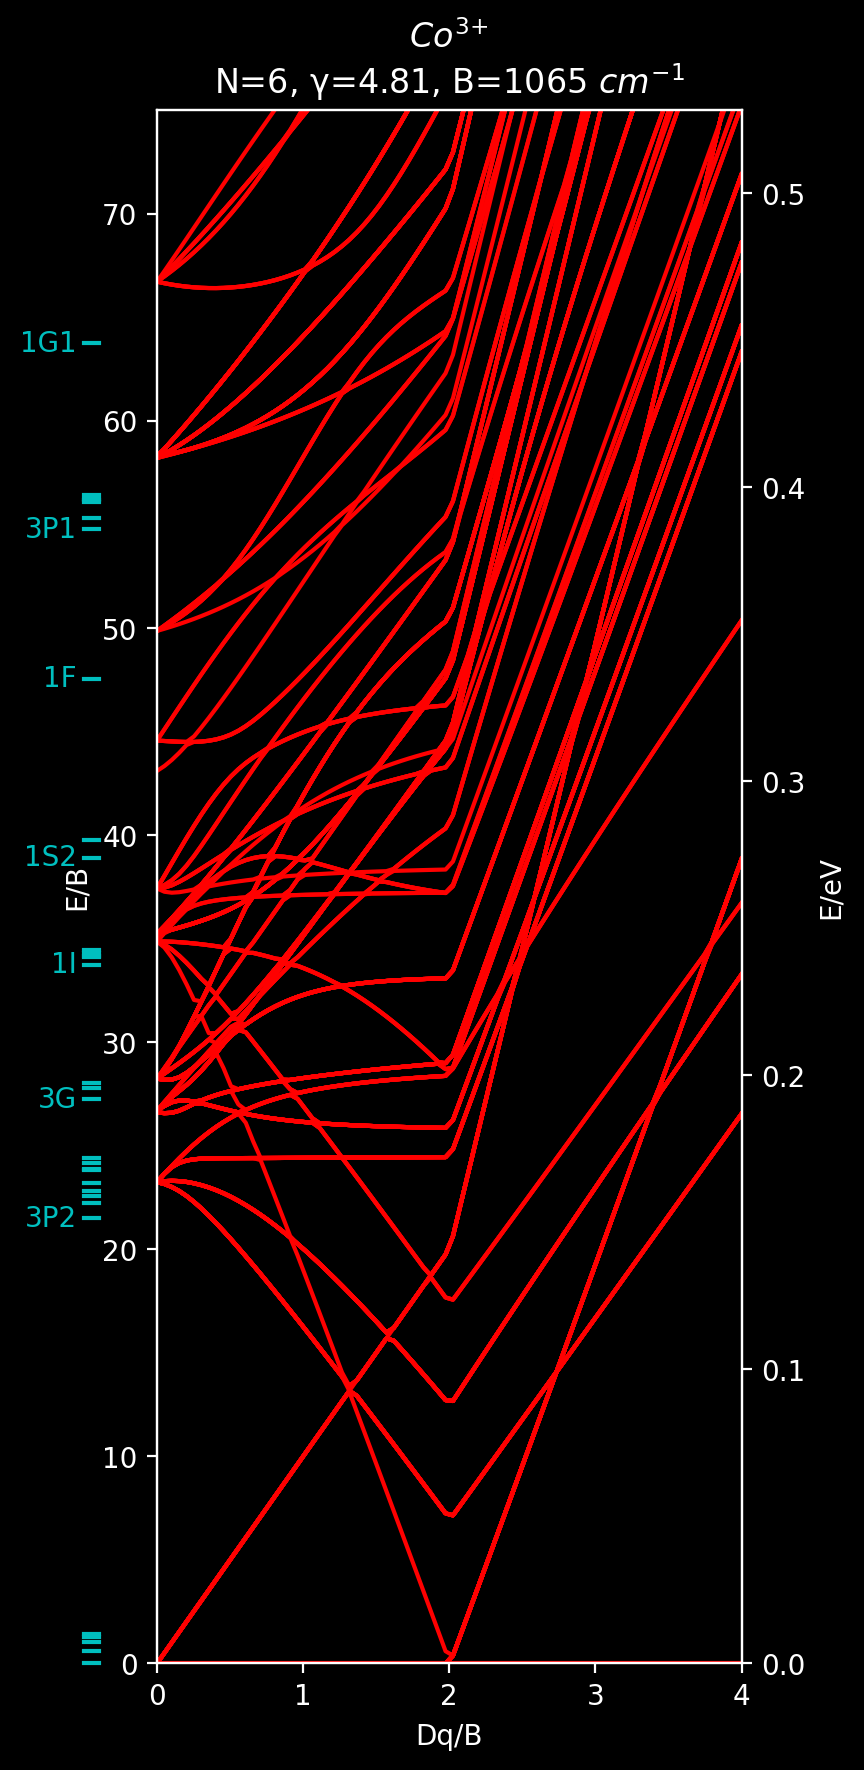

N=7


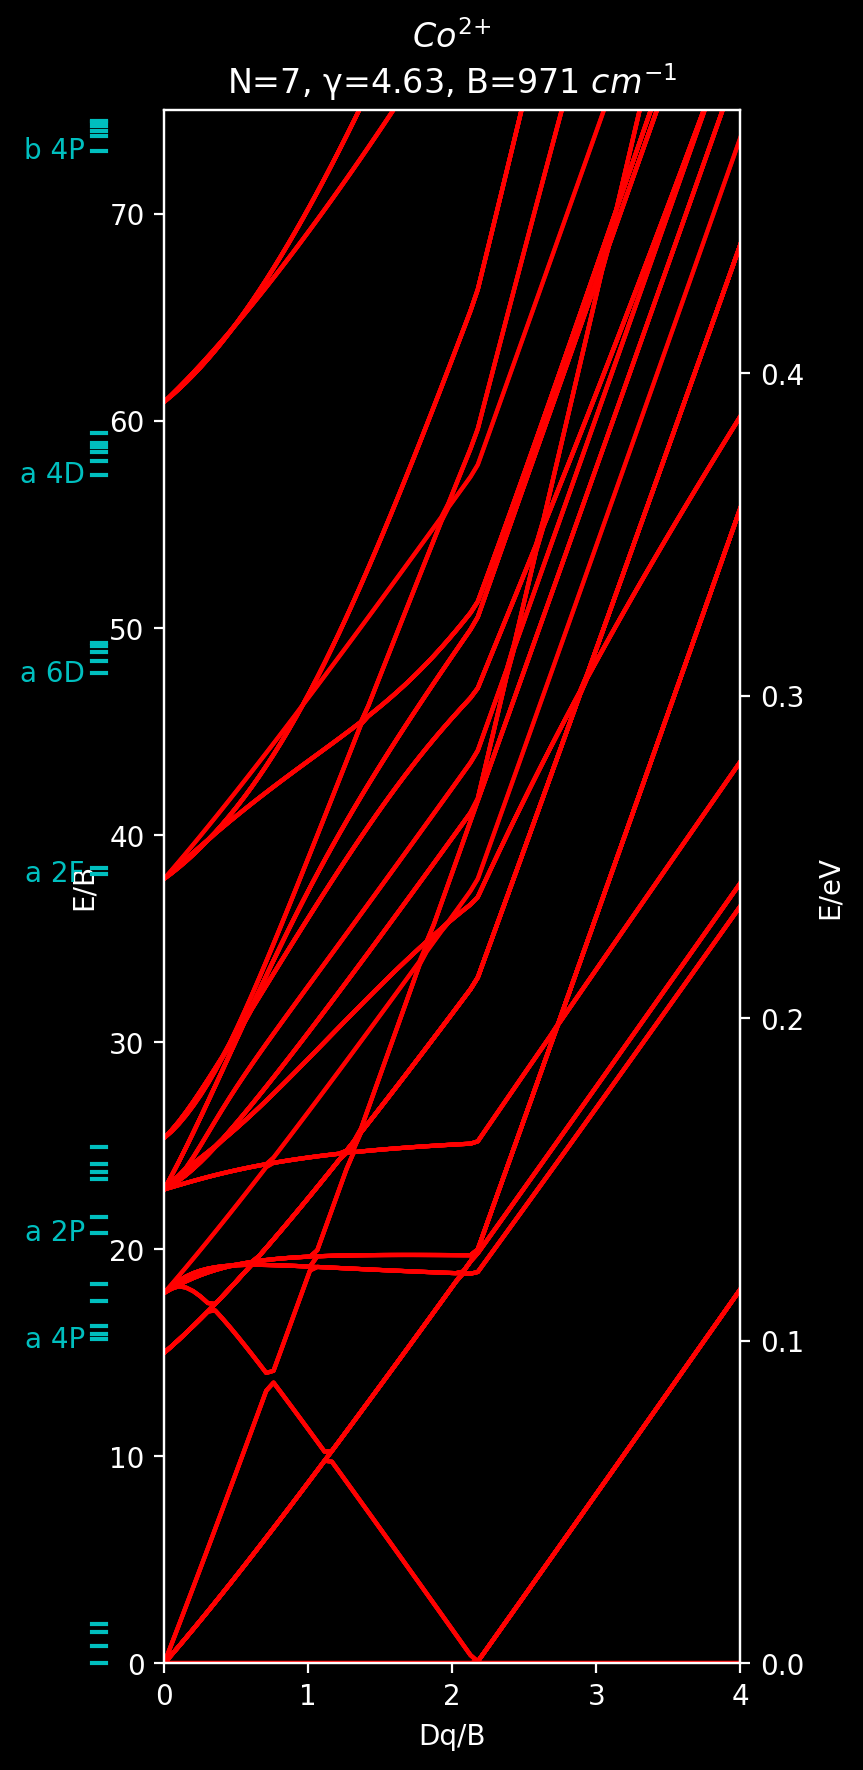

N=8


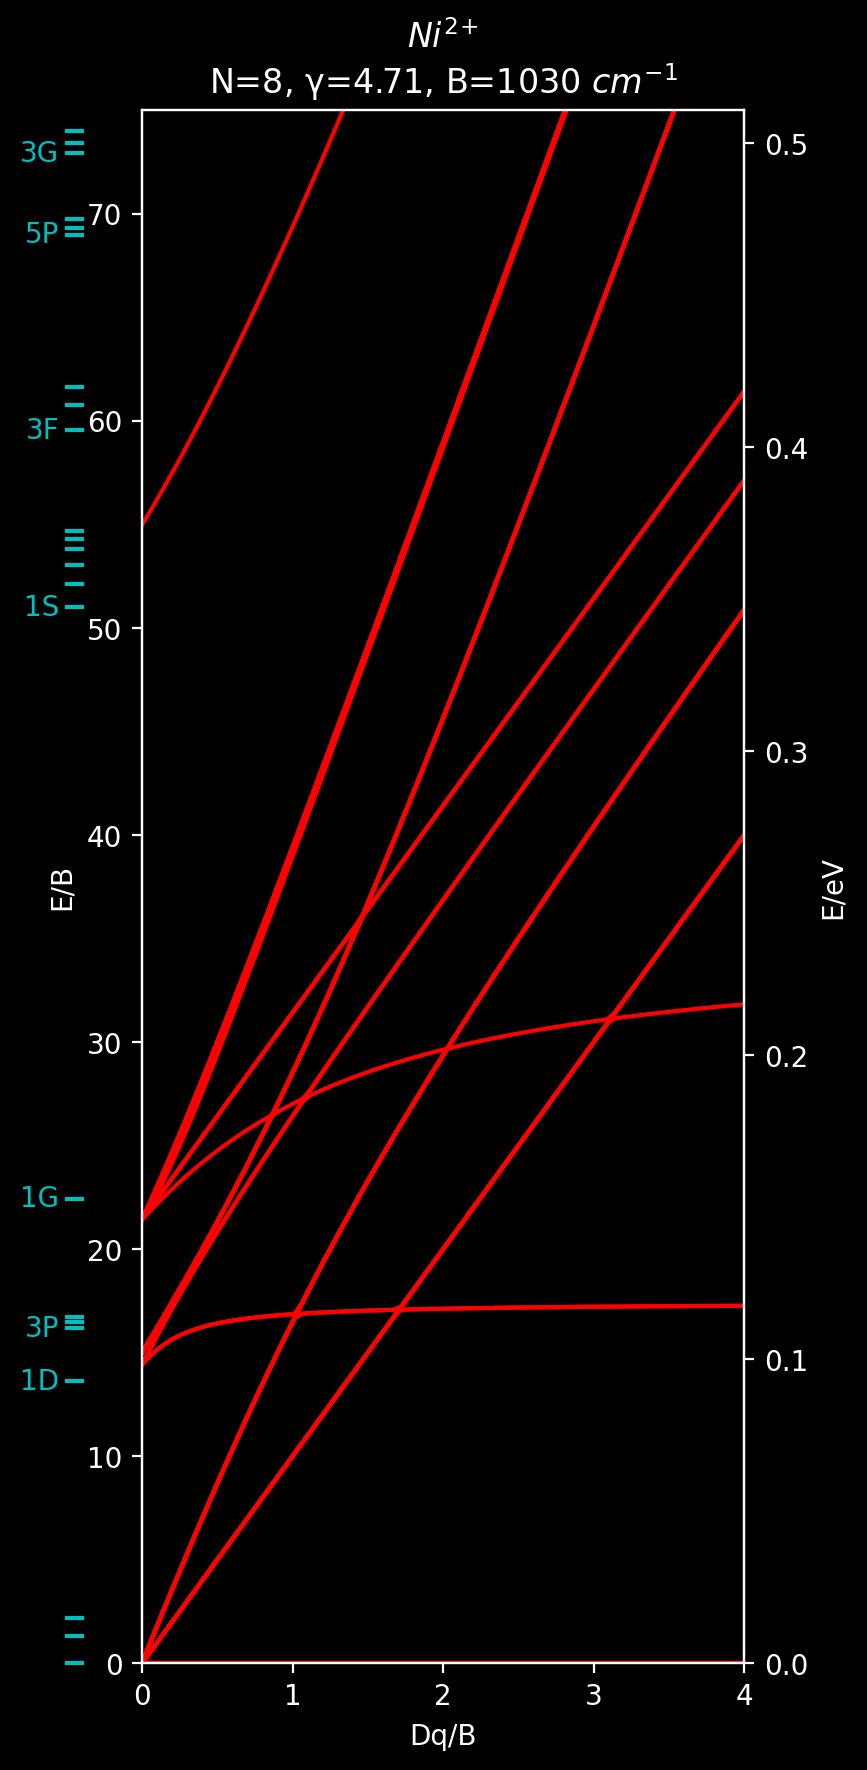

In [104]:

γexps = {2: 4.42, 3: 4.50, 4: 4.61, 5: 4.48, 6: 4.81, 7: 4.63, 8: 4.71}
Bexps =  {2: 860, 3:918 , 4:965 , 5:860, 6: 1065, 7: 971, 8:1030}
atoms = dict(zip([2,3,4,5,6,7,8], 'V,3 Cr,3 Mn,3 Mn,2 Co,3 Co,2 Ni,2'.split(' ')))
Dqs = np.linspace(0,4,80)
ymax = 75

for num_electrons in [2,3,4,5,6,7,8]:
    print('N=%d' % num_electrons)
    atom = atoms[num_electrons].split(',')[0]
    charge_state =  int(atoms[num_electrons].split(',')[1])
    γexp = γexps[num_electrons]
    ion = Ion(atom, charge_state)
    Bexp = Bexps[num_electrons]

    single_e_basis = component_labels[sp.Symbol('E')] + component_labels[sp.Symbol('T_2')]
    # add spin up and spin down
    spin_orbitals = single_e_basis + [bar_symbol(v) for v in single_e_basis]
    # create determinantal states
    slater_dets = list(combinations(spin_orbitals,num_electrons))
    slater_qets = [Qet({k:1}) for k in slater_dets]

    hamiltonian = []
    for qet0 in slater_qets:
        row = []
        for qet1 in slater_qets:
            double_braket = double_electron_braket(qet0,qet1)
            coulomb_matrix_element = braket_basis_change(double_braket, basis_change)
            coulomb_matrix_element = coulomb_matrix_element.apply(to_slater_params)
            coulomb_matrix_element = sp.expand(coulomb_matrix_element.as_symbol_sum()).subs(slater_to_Racah)
            nuclear_charge_energy = single_electron_braket(qet0,qet1).apply(simple_energy).as_symbol_sum()
            row.append(coulomb_matrix_element + nuclear_charge_energy)
        hamiltonian.append(row)
    hamiltonian = sp.Matrix(hamiltonian)
    num_ham = hamiltonian.subs({sp.Symbol('A'):0, sp.Symbol('C'): γexp, sp.Symbol('B'):1})

    eigen_array = []
    for Dq in Dqs:
        the_ham_array = np.array(num_ham.subs({sp.Symbol('Dq'): Dq})).astype(np.float64)
        the_eigenvalues = np.sort(np.linalg.eig(the_ham_array)[0])
        the_eigenvalues = np.real(the_eigenvalues - np.min(the_eigenvalues))
        eigen_array.append(the_eigenvalues)
    
    eigen_array = np.array(eigen_array).T
    exp_levels = ion.nist_data['Level (eV)'] * UnitCon.con_factor('eV','cm^{-1}')/Bexp
    term_labels =  ion.nist_data['Term']
    selector = exp_levels<ymax
    exp_levels = exp_levels[selector]
    term_labels = term_labels[selector]

    fig, ax = plt.subplots(figsize=(3*1.5,6*1.5))

    for row in eigen_array:
        plt.plot(Dqs,row,'r')
    y_str = []
    for exp_level, term_label in zip(exp_levels, term_labels):
        line = plt.Line2D([-0.5,-0.4],[exp_level]*2,c='c')
        line.set_clip_on(False)
        ax.add_line(line)
        if len(y_str)>0 and min(([abs(ys - exp_level) for ys in y_str])) > 2:
            plt.text(-0.55,exp_level,term_label,ha='right', va='center', c='c')
        y_str.append(exp_level)
    plt.xlim(0,Dqs[-1])
    plt.ylim(0,ymax)
    plt.xlabel('Dq/B')
    plt.ylabel('E/B')
    axright = ax.twinx()  # instantiate a second axes that shares the same x-axis
    axright.set_ylim(0, Dqs[-1]*Bexp*UnitCon.con_factor('cm^{-1}','eV'))
    axright.set_ylabel('E/eV')
    plt.title('$%s^{%d\!+}$\nN=%d, γ=%.2f, B=%.0f $cm^{-1}$' % (atom, charge_state, num_electrons, γexp, Bexp))
    plt.tight_layout()
    plt.savefig('TSK-%d.pdf' % num_electrons)
    plt.show()

# First Approach - The Big Dumb Matrix Approach

<center> 
This is a diagram for Vanadium IV, reproduce it. <br> <br>

<img src="notebook_imgs/2022-01-03-16-22-14.png" style="width: 25%;"/> 
</center>

Given a number of electrons in the d-subshell 
determine what are the possible configurations,

and then, as a function of Dq/B
it's easy to start from a free-ion term, and figure out how it would split under the crystal field
but since there are repeated terms, how would I know then from which free-ion term is can be
seen to have originated from?
If I were to set the crystal-field strength to zero, (which still leaves the Coulomb repulsion still on), this should
group the terms in groups that should belong to a single free-ion term, then I might be able to identify which one it is
by finding the match within the possible set of possibilities.
that is, I first need to obtain final

In [35]:
subs = {sp.Symbol('F_{(4)}') : sp.Symbol('F^{(4)}')/441,
        sp.Symbol('F_{(0)}'): sp.Symbol('F^{(0)}'),
        sp.Symbol('F_{(2)}'): sp.Symbol('F^{(2)}')/49}
A = sp.Symbol('F_{(0)}') - 49 * sp.Symbol('F_{(4)}')
A = A.subs(subs)
B = sp.Symbol('F_{(2)}') - 5 * sp.Symbol('F_{(4)}')
B = B.subs(subs)
C = 35*sp.Symbol('F_{(4)}')
C = C.subs(subs)
slater_to_Racah = sp.solve([sp.Symbol('A') - A, 
                        sp.Symbol('B') - B,
                        sp.Symbol('C') - C],(sp.Symbol('F^{(0)}'), sp.Symbol('F^{(2)}'), sp.Symbol('F^{(4)}')))

In [4]:
four_real_var_ids, four_symbol_ids, two_real_var_ids, two_symbol_ids, simplifier = braket_identities('O', assume_real = False, verbose = True)

O Creating all 4-symbol identities ...
O Refining set of identities ...
O Finding trivial zeros ...
O Using them to simplify things ...
O Creating reality identities ...
O Solving for independent 4-symbol brakets ...
O Creating a dictionary with all the 4-symbol replacements ...
O Creating all 2-symbol identities ...
O Creating set of 2 symbol identities ...
O Finding trivial zeros ...
O Using them to simplify things ...
O Creating reality identities ...
O Solving for independent 2-symbol brakets ...
O Creating a dictionary with all the 2-symbol replacements ...


In [348]:
group_label = 'O'
l = 2
group = CPGs.get_group_by_label(group_label)
irreps = group.irrep_labels
sym_bases = {k: v[l] for k,v in symmetry_bases[group_label][1].items() if v[l]}
component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
basis_change = {}
for irrep, qets in sym_bases.items():
    components = component_labels[irrep]
    if isinstance(qets, list):
        qets = qets[0]
    for component, qet in zip(components, qets):
        basis_change[component] = qet
# basis_change[sp.Symbol('{\\xi}')] = - basis_change[sp.Symbol('{\\xi}')]


In [349]:
two_electrons = []
for config in config_layout('O', 2, 2):
    Γ1s = config[0]
    if len(config) == 1:
        Γ2s = []
    else:
        Γ2s = config[1]
    two_electrons.append((config,CrystalElectronsLLCoupling('O', Γ1s, Γ2s)))

In [350]:
terms = {}
for wave_key, wave_qet in two_electrons[1][1].equiv_waves.items():
    aterm = wave_key.terms[-1]
    if aterm not in terms:
        terms[aterm] = {}
    terms[aterm][wave_key] = wave_qet
terms = OrderedDict(sorted(list(terms.items()), key=lambda x: x[0][0]))

In [351]:
all_terms = OrderedDict()
Λ = namedtuple('Λ',['electrons','term','γ']) 
for two_e_config in two_electrons:
    for wave_key, wave_qet in two_e_config[1].equiv_waves.items():
        λ = Λ(electrons=tuple(two_e_config[0]),term=wave_key.terms[-1], γ = wave_key.γ)
        term_sector = wave_key.terms[-1][1]
        component_pivot = component_labels[term_sector][0]
        if λ not in all_terms and component_pivot == wave_key.γ:
            all_terms[λ] = (wave_key, wave_qet)
        # all_terms[λ] = (wave_key, wave_qet)

<center> <img src="notebook_imgs/2022-01-05-11-35-51.png" style="width: 50%;"/> </center>

This in turn simplifies to 6 <ξη||ζu> = 6 B = 6/49 F^2 - 10/147 F^4

In [364]:
energy_matrix = []
term_keys = list(all_terms.keys())
term_keys = sorted(term_keys, key = lambda x: str(x.term[1]))
gamma_ratio = {sp.Symbol('C'): sp.Symbol('\\gamma_{CB}') * sp.Symbol('B')}
for λ0 in term_keys:
    row = []
    qet_key_0 = all_terms[λ0][0]
    qet_0 = all_terms[λ0][1]
    for λ1 in term_keys:
        qet_key_1 = all_terms[λ1][0]
        qet_1 = all_terms[λ1][1]
        matrix_element = double_electron_braket(qet_0,qet_1)
        matrix_element = simplifier(matrix_element)
        matrix_element = braket_basis_change(matrix_element, basis_change)
        matrix_element = matrix_element.apply(to_slater_params)
        mat_element = sp.expand(matrix_element.as_symbol_sum()).subs(slater_to_Racah)
        mat_element = mat_element.subs(gamma_ratio)
        single_elec_element = single_electron_braket(qet_0, qet_1).apply(another_simplifier).as_symbol_sum()
        row.append(mat_element + single_elec_element)
    energy_matrix.append(row)
energy_matrix = sp.Matrix(energy_matrix)

NOTE: A doesn't matter 'cause it just raises all the energies by the same amount. At least on this example.

In [365]:
ts2gtkv = [l.strip() for l in open("/Users/juan/Zia Lab/Codebase/qdef/data/tsdiag2.txt",'r').readlines()];
ts2gtk = ts2gtkv[::2]
ts2gtv = [np.array(eval(l)) for l in ts2gtkv[1::2]]

In [366]:
zeroCF = list((energy_matrix.subs({sp.Symbol('A'):0,sp.Symbol('B_{4,0}'):0,sp.Symbol('B'):1}).eigenvals()).items())
zeroCF = list(sorted(zeroCF, key = lambda x: x[0].subs({sp.Symbol('\\gamma_{CB}'):γexp})))
zeroCF = [(k-zeroCF[0][0],v) for k,v in zeroCF]

In [367]:
a_Bohr = 5.29e-11 * 100 # in cm
e_squared = (4.80320425e-10)**2 # in erg X cm
# γexp = 4.42
# Bexp = 860
γexp = 4.42
Bexp = 860
# to convert slater integrals to energies in cm^{-1}
con_fact = e_squared/a_Bohr*UnitCon.con_factor('erg','cm^{-1}') 
Fddreps = {sp.Symbol('F^{(%d)}' % k) : con_fact*SlaterFddSTK(k,1) for k in [0,2,4]}

# replace in favor of
energy_matrix_rep = energy_matrix.subs({sp.Symbol('B_{4,0}'): 21 * sp.Symbol('Dq')})
# divide matrix by B
energy_matrix_rep = sp.expand(energy_matrix_rep/sp.Symbol('B'))
# replace by Bexp
subs = {sp.Symbol('B'): Bexp, sp.Symbol('\\gamma_{CB}'): γexp, sp.Symbol('A'): 0*A.subs(Fddreps)}
energy_matrix_rep = energy_matrix_rep.subs(subs)


In [368]:
# checking asymptotic behaviour
largeDq = 1e100
this_em = energy_matrix_rep.subs({sp.Symbol('Dq'):largeDq})
this_em = np.array(this_em).astype(np.float64)
eigenvals, eigenvects = np.linalg.eig(this_em)
eigenvals = np.sort(eigenvals)/largeDq
eigenvals = eigenvals - np.min(eigenvals)
eigenvals = Bexp*eigenvals
np.round(eigenvals,2)

array([ 0.,  0.,  0.,  0., 10., 10., 10., 10., 20., 20., 20.])

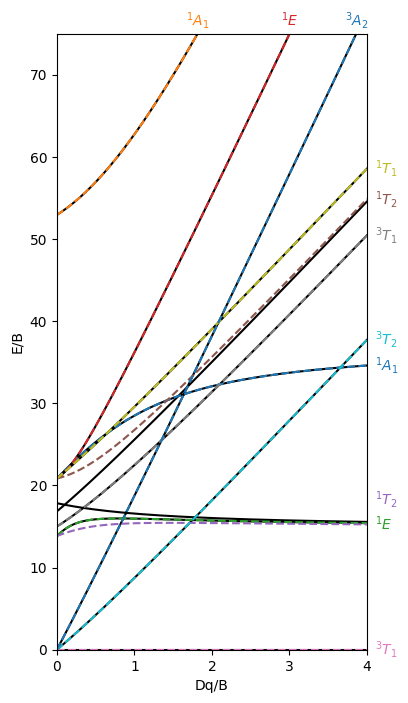

In [369]:
Dqs = np.linspace(0, 4*Bexp, 200)
diagram = []
all_eigenvects = []
ymax = 75
for Dq in Dqs:
    this_em = energy_matrix_rep.subs({sp.Symbol('Dq'):Dq})
    this_em = np.array(this_em).astype(np.float64)
    eigenvals, eigenvects = np.linalg.eig(this_em)
    sorter = np.argsort(eigenvals)
    eigenvals = eigenvals[sorter]
    eigenvects = eigenvects[sorter]
    diagram.append(eigenvals)
    all_eigenvects.append(eigenvects)
diagram = np.array(diagram).T
plt.figure(figsize=(4,8))
row0 = diagram[0]
for row in diagram:
    plt.plot(Dqs/Bexp, row-row0,'k-')
# for tsgt, label in zip(ts2gtv,ts2gtk):
#     plt.plot(tsgt[:,0],tsgt[:,1],'--', label=label)

Dqsr = np.linspace(0, 4, 200)
base = TSK_functions[(1,sp.Symbol('T_1'))][0](Dqsr, γexp)
y_strs = []
for term_key, functions in TSK_functions.items():
    for function in functions:
        label_str = '${}^{%d}%s$' % (term_key[0]*2+1,sp.latex(term_key[1]))
        p = plt.plot(Dqsr, function(Dqsr, γexp) - base, '--')
        col = p[0].get_color()
        y_str = function(Dqsr[-1], γexp) - base[-1]
        if y_str < ymax:
            if len(y_strs)>0:
                if np.min(np.abs(np.array(y_strs)-y_str)) < 2:
                    y_str += 3
            plt.text(Dqsr[-1]+0.1, y_str,label_str, c = col, va='center')
            y_strs.append(y_str)
        else:
            x_str = np.interp(ymax, function(Dqsr, γexp) - base, Dqsr)
            plt.text(x_str, ymax+1, label_str, c = col, ha ='center')

plt.ylim(0,ymax)
plt.xlim(Dqs[0]/Bexp,Dqs[-1]/Bexp)
plt.xlabel('Dq/B')
plt.ylabel('E/B')
plt.show()

## Trunk 

In [70]:
# # building the full configuration matrix
# energy_matrix = []
# for term_0, term_qets_0 in terms.items():
#     term_symbol_0 = sp.Symbol('{}^{%d}%s' % (term_0[0]*2+1, sp.latex(term_0[1])))
#     a_key_0 = list(term_qets_0.keys())[0]
#     a_qet_0 = term_qets_0[a_key_0]
#     row = []
#     for term_1, term_qets_1 in terms.items():
#         term_symbol_1 = sp.Symbol('{}^{%d}%s' % (term_1[0]*2+1, sp.latex(term_1[1])))
#         a_key_1 = list(term_qets_1.keys())[0]
#         a_qet_1 = term_qets_1[a_key_1]
#         matrix_element = double_electron_braket(a_qet_0,a_qet_1)
#         matrix_element = simplifier(matrix_element)
#         # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
#         matrix_element = braket_basis_change(matrix_element, basis_change)
#         # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
#         # display(matrix_element.as_braket())
#         matrix_element = matrix_element.apply(to_slater_params)
#         for electron in a_key.electrons:
#             cf_energy = sp.Symbol('E_{CF}(%s)' % (sp.latex(electron).lower()))
#             matrix_element = matrix_element + Qet({cf_energy:1})
#         # cf_energy = sp.Symbol('E_{CF}(%s, %s, %s)' % (sp.latex(a_key.electrons).lower(),sp.latex(a_key.terms[-1]),sp.latex(a_key.γ)))
#         # matrix_element = matrix_element + Qet({cf_energy:1})
#         # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_symbol_sum()))))
#         row.append(matrix_element.as_symbol_sum())
#     energy_matrix.append(row)
# energy_matrix = sp.Matrix(energy_matrix)

In [ ]:
# # test of three harmonic integral
# "ll' mm' k"
# inputstrings = ['s p 0 1 1', 'p d 1 2 1', 's f 0 3 3', 'd f 2 3 1' ,'d f 2 3 3', 's s 0 0 0', 's d 0 2 2', 'p p 1 1 2', 'p f 1 3 2', 'd f 2 2 3', 'f f 3 -3 6']
# gts = [-sp.S(1)/sp.sqrt(3), -sp.sqrt(6)/sp.sqrt(15), -1/sp.sqrt(7), -sp.sqrt(15)/sp.sqrt(35), sp.sqrt(10)/(sp.sqrt(35)*3), 1, 1/sp.sqrt(5), -1/sp.S(5), 3*sp.sqrt(5)/(5*sp.sqrt(7)), -2*sp.sqrt(5)/(3*sp.sqrt(35)), -10*sp.sqrt(231)/429]
# for gt, inputstring in zip(gts, inputstrings):
#     l, lp, m, mp, k = inputstring.split(' ')
#     m = int(m)
#     mp = int(mp)
#     k = int(k)
#     mk = m - mp
#     l, lp = [{'s':0,'p':1,'d':2,'f':3}[el] for el in [l,lp]]
#     val = sp.sqrt((4*sp.pi) / (2*k+1)) * threeHarmonicIntegral(l,m,k,mk,lp,mp)
#     if val == gt:
#         print("|✓|", val,)
#     else:
#         print(l, lp, m, mp, k , '|',inputstring, '|', val, gt)

In [ ]:
# basis_change_raw = dict(basis_change)
# # sign tweaking
# irrep = sp.Symbol('T_1')
# good_signs = []
# for sign_gauge in product(*[[-1,1]]*5):
#     basis_change = dict(basis_change_raw)
#     counter = 0
#     for k in basis_change:
#         basis_change[k] = sign_gauge[counter]*basis_change[k]
#         # basis_change[k] = choice([-1,1])*basis_change[k]
#         counter += 1
#     good_counter = 0
#     for component in component_labels[irrep]:
#         # if component != sp.Symbol('{\\mu}'):
#         #     continue
#         # display(component)
#         a_term = []
#         # Λ = namedtuple('Λ',['electrons','term'])
#         agamma = ''
#         for two_e_config in two_electrons:
#             for wave_key, wave_qet in two_e_config[1].equiv_waves.items():
#                 if wave_key.terms[-1] != (1,irrep):
#                     continue
#                 if wave_key.γ != component:
#                     continue
#                 if wave_key.M != 0:
#                     continue
#                 a_term.append((wave_key,wave_qet))
#         # print("len",len(a_term))
#         bra = a_term[0][1]
#         ket = a_term[1][1]
#         # display(bra.as_ket())
#         # display(ket.as_ket())
#         # print("bra",a_term[0][0])
#         # print("ket",a_term[1][0])
#         abraket = simplifier(double_electron_braket(bra,ket))
#         final_braket = braket_basis_change(abraket, basis_change).apply(to_slater_params)
#         # print(final_braket.dict[sp.Symbol('F^{(2)}')])
#         if(final_braket.dict[sp.Symbol('F^{(2)}')] == sp.S(6)/49):
#             if(final_braket.dict[sp.Symbol('F^{(4)}')] == -sp.S(10)/147):
#                 good_counter += 1
#     if good_counter == 3:
#         good_signs.append(sign_gauge)
    

In [ ]:
# for k, v in basis_change.items():
#     display(k)
#     display(v.as_ket())

In [ ]:
# # The diagonal is correct
# display(simplifier(double_electron_braket(bra,bra)).as_braket())
# display(simplifier(double_electron_braket(ket,ket)).as_braket())

In [ ]:
# Bexp = 860
# shifts = {Λ(electrons=((sp.Symbol('T_2'), 2),), term=(0, sp.Symbol('A_1'))): Bexp*20,
#  Λ(electrons=((sp.Symbol('T_2'), 2),), term=(0, sp.Symbol('E'))): Bexp*12,
#  Λ(electrons=((sp.Symbol('T_2'), 2),), term=(1, sp.Symbol('T_1'))): Bexp*0,
#  Λ(electrons=((sp.Symbol('T_2'), 2),), term=(0, sp.Symbol('T_2'))): Bexp*12,
#  Λ(electrons=((sp.Symbol('E'), 1), (sp.Symbol('T_2'), 1)), term=(1, sp.Symbol('T_2'))): Bexp*0,
#  Λ(electrons=((sp.Symbol('E'), 1), (sp.Symbol('T_2'), 1)), term=(1, sp.Symbol('T_1'))): Bexp*15,
#  Λ(electrons=((sp.Symbol('E'), 1), (sp.Symbol('T_2'), 1)), term=(0, sp.Symbol('T_2'))): Bexp*10,
#  Λ(electrons=((sp.Symbol('E'), 1), (sp.Symbol('T_2'), 1)), term=(0, sp.Symbol('T_1'))): Bexp*20,
#  Λ(electrons=((sp.Symbol('E'), 2),), term=(0, sp.Symbol('A_1'))): Bexp*52,
#  Λ(electrons=((sp.Symbol('E'), 2),), term=(0, sp.Symbol('E'))): Bexp*20,
#  Λ(electrons=((sp.Symbol('E'), 2),), term=(1, sp.Symbol('A_2'))): Bexp*0
#  }

In [ ]:
# def determine_irrep(component):
#     matches = [ir for ir, comps in component_labels.items() if component in comps]
#     if len(matches) == 1:
#         return matches[0]
#     else:
#         raise Exception("Invalid component")

# def a_simplifier(qnums, coeff):
#     l1, m1, l2, m2 = qnums
#     if m1 == m2:
#         return {(1,): coeff}
#     else:
#         return {}

# def another_simplifier(qnums, coeff):
#     γ1, γ2  = qnums
#     if γ1 == γ2:
#         the_irrep = determine_irrep(γ1)
#         if the_irrep == sp.Symbol('E'):
#             return {sp.Symbol('B_{4,0}'): coeff*sp.S(2)/7}
#         elif the_irrep == sp.Symbol('T_2'):
#             return {sp.Symbol('B_{4,0}'): (-1)*coeff*sp.S(4)/21}
#         else:
#             1/0
#     else:
#         return {}

# def two_braket_basis_change(braket, basis_changer):
#     '''
#     Take  a  qet,  understood  as  a  TWO  symbol braket, and a
#     dictionary  that  maps  the  current basis to a new one, and
#     return  the resulting expression for the new braket in terms
#     of  the new basis. All throughout it is assumed that between
#     the given braket there is an implicit operator.

#     Parameters
#     ----------
#     braket   (qdefcore.Qet)
#     basis_changer (dict):  keys being  equal  to single electron
#     quantum  symbols  and  values  to  qets  that  determine the
#     superposition of the new basis to which this vector is being
#     mapped to. The keys of the dictionary need not  include  all
#     the quantum symbols included in the qet.

#     Returns
#     -------
#     new_braket (qdefcore.Qet)

#     Example
#     -------

#     braket = Qet({(1,2,3,4): 5,
#                 (8,4,3,1): 1})
#     basis_change = {1: Qet({(8,): sp.I})}
#     print(braket_basis_change(braket, basis_change))
#     >> {(8, 2, 3, 4): -5*I, (8, 4, 3, 8): I}

#     '''

#     new_braket = Qet({})
#     for k, v in braket.dict.items():
#         βi, βj = [(Qet({(γ,):1}) if γ not in basis_changer else basis_changer[γ]) for γ in k]
#         βi = βi.dual()
#         γiγj = (βi * βj)
#         new_braket = new_braket + (v*γiγj)
#     return new_braket

In [74]:
# term_energies = {}
# for term, term_qets in terms.items():
#     term_symbol = sp.Symbol('{}^{%d}%s' % (term[0]*2+1, sp.latex(term[1])))
#     a_key = list(term_qets.keys())[0]
#     a_qet = term_qets[a_key]
#     matrix_element = double_electron_braket(a_qet,a_qet)
#     matrix_element = simplifier(matrix_element)
#     # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
#     matrix_element = braket_basis_change(matrix_element, basis_change)
#     # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
#     # display(matrix_element.as_braket())
#     matrix_element = matrix_element.apply(to_slater_params)
#     for electron in a_key.electrons:
#         cf_energy = sp.Symbol('E_{CF}(%s)' % (sp.latex(electron).lower()))
#         matrix_element = matrix_element + Qet({cf_energy:1})
#     # cf_energy = sp.Symbol('E_{CF}(%s, %s, %s)' % (sp.latex(a_key.electrons).lower(),sp.latex(a_key.terms[-1]),sp.latex(a_key.γ)))
#     # matrix_element = matrix_element + Qet({cf_energy:1})
#     # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_symbol_sum()))))
#     term_energies[term] = matrix_element

In [37]:
list(ion.nist_data['Configuration'])[:10]

['3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d.4s']

In [34]:
list(zip(ion.nist_data['Term'], list((ion.nist_data['Level (eV)'] * UnitCon.con_factor('eV','cm^{-1}')) / 860)))

[('3F', 0.0),
 ('3F', 0.37833028199975877),
 ('3F', 0.8542911598254345),
 ('1D', 12.743371853634908),
 ('3P', 15.259071279604548),
 ('3P', 15.394403604077938),
 ('3P', 15.649218521329635),
 ('1G', 21.38513325784556),
 ('1S', 49.3745402212293),
 ('3D', 111.85596448573929),
 ('3D', 112.10712177259981),
 ('3D', 112.55579110058366),
 ('1D', 116.51240932988604),
 ('1D*', 167.7593749552118),
 ('3D*', 169.90434071614797),
 ('3D*', 170.26663369566336),
 ('3D*', 170.7617267939967),
 ('3F*', 171.08744346960034),
 ('3F*', 171.69357847519393),
 ('3F*', 172.52236000767581),
 ('3P*', 176.07795188947426),
 ('3P*', 176.1036490876071),
 ('3P*', 176.2410446907627),
 ('1F*', 178.97526408625623),
 ('1P*', 180.89008048873245),
 ('1F', 251.11358286661928),
 ('3D', 252.21509232673014),
 ('3D', 252.45115016505272),
 ('3D', 252.73260013438374),
 ('3G', 253.29803227870116),
 ('3G', 253.60461673379712),
 ('3G', 254.02740129285885),
 ('1P', 253.47753752405256),
 ('3S', 256.213351271255),
 ('3F', 259.0634894145304

In [3]:
config_layout('O', 2, 2)

[[(T_2, 2)], [(E, 1), (T_2, 1)], [(E, 2)]]

In [ ]:
t23 = CrystalElectronsLLcoupling('O',(sp.Symbol('E'),2), (sp.Symbol('T_2'),4))

In [ ]:


terms = {}
for wave_key, wave_qet in t23.equiv_waves.items():
    aterm = wave_key.terms[-1]
    if aterm not in terms:
        terms[aterm] = {}
    terms[aterm][wave_key] = wave_qet
terms = OrderedDict(sorted(list(terms.items()), key=lambda x: x[0][0]))

for term, term_qets in terms.items():
    display(sp.Symbol('+'*10))
    term_symbol = sp.Symbol('{}^{%d}%s' % (term[0]*2+1, sp.latex(term[1])))
    a_key = list(term_qets.keys())[0]
    a_qet = term_qets[a_key]
    matrix_element = double_electron_braket(a_qet,a_qet)
    matrix_element = simplifier(matrix_element)
    display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
    matrix_element = braket_basis_change(matrix_element, basis_change)
    # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
    # display(matrix_element.as_braket())
    matrix_element = matrix_element.apply(to_slater_params)
    display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_symbol_sum()))))
    # display(ground_truth[term])